In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from scipy.stats import norm
from scipy import stats

I want to tank Alfred Kondoro for the "exploring-kobe-bryants-nba-journey" dataset (https://www.kaggle.com/datasets/alfredkondoro/exploring-kobe-bryants-nba-journey). As a huge Kobe fan for me is an honour perfoming explorative data analysis on this dataset. This analysis aims to explore the main characteristics of the dataset, clean the data, identify the key target features and normalize them. Moreover, toward the end, we will formulate an hypothesis to see if there are key differences between the Kobe that used to wear the number 8 and the Kobe that use to wear the number 24 in influencing the target feature point_difference (point difference between the two teams at the end of a game). This feature not only indicates if the Lakers won that game, but also of how much, and together with other correlated features, it is a great way of solving one of the biggest debates in the NBA history: which Kobe was the strongest?

In [3]:
#load the kobebryant dataset
kobe = pd.read_csv("kobebryant.csv")
kobe.head(5)

,season,date,age,team_played,game_type,venue,opponent,win_lose,minutes_played,point_difference,...,total_rebounds,assists,steals,blocks,turnovers,personal_fouls,points,fieldgoal_percent,3pointers_percent,freethrow_percent
0,4,6/19/2000,21,los angeles lakers,playoff,away,indian pacers,w,44:44:00,5,...,10,4,1,2,1,4,26,0.3,0.33,0.89
1,14,6/17/2010,31,los angeles lakers,playoff,away,boston celtics,w,44:51:00,4,...,15,2,1,0,4,4,23,0.25,0,0.73
2,12,6/17/2008,29,los angeles lakers,playoff,home,boston celtics,l,42:46:00,-39,...,3,1,1,0,4,NaN,NaN,0.32,0.33,1
3,4,6/16/2000,21,los angeles lakers,playoff,home,indian pacers,l,36:44:00,-33,...,5,3,2,0,0,5,8,0.2,0,NaN
4,14,6/15/2010,31,los angeles lakers,playoff,away,boston celtics,w,39:37:00,22,...,11,3,4,0,2,2,26,0.47,0.25,1


In [4]:
#Let's find more information on the features and types
kobe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1777 entries, 0 to 1776
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   season              1777 non-null   int64 
 1   date                1777 non-null   object
 2   age                 1777 non-null   int64 
 3   team_played         1777 non-null   object
 4   game_type           1777 non-null   object
 5   venue               1777 non-null   object
 6   opponent            1777 non-null   object
 7   win_lose            1777 non-null   object
 8   minutes_played      1777 non-null   object
 9   point_difference    1777 non-null   int64 
 10  game_started        1777 non-null   object
 11  fieldgoal           1777 non-null   object
 12  fieldgoal_attempts  1777 non-null   object
 13  3pointers           1777 non-null   object
 14  3pointers_attempts  1777 non-null   object
 15  freethrows          1777 non-null   object
 16  freethrows_attempt  1777

In [5]:
kobe.describe()

,season,age,point_difference
count,1777.000000,1777.000000,1777.000000
mean,10.462015,27.462015,2.272369
std,5.666883,5.666883,13.385782
min,1.000000,18.000000,-48.000000
25%,6.000000,23.000000,-7.000000
50%,11.000000,28.000000,4.000000
75%,15.000000,32.000000,11.000000
max,20.000000,37.000000,55.000000


In [6]:
#let's describe some of the numerical features of the dataset
#point differences tells also if the match was won (positive) or lost (negative)
#let's see the descriptive statistics of this feature, since this could become the target feature
kobe['point_difference'].describe()

count    1777.000000
mean        2.272369
std        13.385782
min       -48.000000
25%        -7.000000
50%         4.000000
75%        11.000000
max        55.000000
Name: point_difference, dtype: float64

We can see that if we sum all Kobe's matches, the Lakers have a positive of balance 4038. Even if does not directly shows if they have won more games than lost, this is still a positive indicator.

Many columns have "object" date type, because they have "null" values. Those "null" values need to be converted into "0" and those columns needs to become integer or floats

In [8]:
#convert the respective columns from strings into int and floats
#kobe.replace("Null", 0, inplace=True)

int_columns = list(range(9, 26))
float_columns = list(range(26, 29))

# Convert selected columns to int
kobe.iloc[:, int_columns] = kobe.iloc[:, int_columns].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

# Convert selected columns to float
kobe.iloc[:, float_columns] = kobe.iloc[:, float_columns].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)

In [10]:
def convert_to_minutes(minute_string):
    try:
        if minute_string == ("Null"):
            return 0
        elif minute_string == 0:
            return 0
        else:
            # Split the string into minutes, and seconds
            time_segments = list(map(int, minute_string.split(':')))
            
            # If there are three segments (minutes, seconds, '00'), remove the '00'
            if len(time_segments) == 3:
                # Extract minutes and seconds from the first two components
                minutes, seconds = time_segments[0], time_segments[1]
            else:
                # If there are only two segments, use them as minutes and seconds
                minutes, seconds = time_segments[0], time_segments[1]

            # Calculate total minutes
            return minutes + seconds / 60
    except ValueError:
        return "Unexpected Format"


In [11]:
# Apply the conversion function to the "minutes_played" column
kobe['minutes_played_converted'] = kobe['minutes_played'].apply(convert_to_minutes)

# Find and print values with unexpected format
unexpected_formats = kobe[kobe['minutes_played_converted'] == "Unexpected Format"]['minutes_played']
print("Values with unexpected format:", unexpected_formats.tolist())

Values with unexpected format: []


In [12]:
# Replace 'w' with 1 and 'l' with 0 in the "win_lose" column so we can input the outcomes of the games into our model.
kobe['win_lose'] = kobe['win_lose'].replace({'w': 1, 'l': 0})

Many columns have "object" date type, because they have "null" values. Those "null" values need to be converted into "0" and those columns needs to become integer or floats

In [14]:
#We want to  sure there is not "Null" string or missing values.
#We can easily replace missing values with 0, since "Null" and missing values, in this dataset, mean that Kobe didn't played or that did not make any point.
kobe.replace("Null", 0, inplace=True)

In [15]:
#Before progressing further, we want to create an extra column "point_per_game" that sums up all the points Kobe scored each game
kobe['points_per_game'] = 3 * kobe['3pointers'] + 2 * (kobe['fieldgoal'] - kobe['3pointers']) + kobe['freethrows']
#Let's also create a points_per_minute fieature to standardize the points contribution
kobe['points_per_minute'] = kobe['points'] / kobe['minutes_played_converted']
#Let's replace the NaN values created in this calculation
kobe = kobe.fillna(0)

In [16]:
#We want to cross-check points_per_game and points by showing up the stats of the iconic 81-point game against the Raptors
print(kobe[kobe['points'] == 81])

     season       date  age         team_played game_type venue  \
945      10  1/22/2006   27  los angeles lakers    season  away   

            opponent  win_lose minutes_played  point_difference  ...  blocks  \
945  toronto rapters         1       41:56:00                18  ...       1   

     turnovers  personal_fouls  points  fieldgoal_percent  3pointers_percent  \
945          3               1      81               0.61               0.54   

     freethrow_percent  minutes_played_converted  points_per_game  \
945                0.9                 41.933333               81   

     points_per_minute  
945           1.931638  

[1 rows x 32 columns]


In [17]:
kobe.head(10)

,season,date,age,team_played,game_type,venue,opponent,win_lose,minutes_played,point_difference,...,blocks,turnovers,personal_fouls,points,fieldgoal_percent,3pointers_percent,freethrow_percent,minutes_played_converted,points_per_game,points_per_minute
0,4,6/19/2000,21,los angeles lakers,playoff,away,indian pacers,1,44:44:00,5,...,2,1,4,26,0.30,0.33,0.89,44.733333,26,0.581222
1,14,6/17/2010,31,los angeles lakers,playoff,away,boston celtics,1,44:51:00,4,...,0,4,4,23,0.25,0.00,0.73,44.850000,23,0.512821
2,12,6/17/2008,29,los angeles lakers,playoff,home,boston celtics,0,42:46:00,-39,...,0,4,0,0,0.32,0.33,1.00,42.766667,22,0.000000
3,4,6/16/2000,21,los angeles lakers,playoff,home,indian pacers,0,36:44:00,-33,...,0,0,5,8,0.20,0.00,0.00,36.733333,8,0.217786
4,14,6/15/2010,31,los angeles lakers,playoff,away,boston celtics,1,39:37:00,22,...,0,2,2,26,0.47,0.25,1.00,39.616667,26,0.656289
5,12,6/15/2008,29,los angeles lakers,playoff,away,boston celtics,1,44:20:00,5,...,0,6,4,25,0.38,0.44,0.71,44.333333,25,0.563910
6,8,6/15/2004,25,los angeles lakers,playoff,home,detroit pistons,0,45:34:00,-13,...,0,3,2,24,0.33,0.00,0.91,45.566667,24,0.526701
7,5,6/15/2001,22,los angeles lakers,playoff,home,philadelphia 76ers,1,43:56:00,12,...,1,3,3,26,0.39,0.67,0.91,43.933333,26,0.591806
8,13,6/14/2009,30,los angeles lakers,playoff,home,orlando magic,1,43:18:00,13,...,4,1,2,30,0.44,0.40,1.00,43.300000,30,0.692841
9,4,6/14/2000,21,los angeles lakers,playoff,home,indian pacers,1,46:49:00,2,...,2,3,4,28,0.52,0.00,0.00,46.816667,28,0.598078


In [18]:
#Here it somehow stopped considering all the int converted above (it was doing it earlier)

kobe_num = kobe.select_dtypes(include = ['float64', 'int64'])
kobe_num_corr = kobe_num.corr()['point_difference'][:-1] # -1 means that the latest row is point_difference
top_features = kobe_num_corr[abs(kobe_num_corr) > 0.1].sort_values(ascending=False) #displays pearsons correlation coefficient greater than 0.5
print("There is {} correlated values with point_difference:\n{}".format(len(top_features), top_features))

There is 17 correlated values with point_difference:
point_difference      1.000000
win_lose              0.807520
fieldgoal_percent     0.284266
assists               0.177049
steals                0.173349
freethrow_percent     0.164480
points                0.153749
points_per_game       0.150903
fieldgoal             0.146930
3pointers_percent     0.138125
freethrows            0.125479
freethrows_attempt    0.120389
defensive_rebounds    0.113504
total_rebounds        0.113104
3pointers_attempts   -0.102249
age                  -0.223580
season               -0.223580
Name: point_difference, dtype: float64


In [19]:
kobe_num.head(5)

,season,age,win_lose,point_difference,game_started,fieldgoal,fieldgoal_attempts,3pointers,3pointers_attempts,freethrows,...,blocks,turnovers,personal_fouls,points,fieldgoal_percent,3pointers_percent,freethrow_percent,minutes_played_converted,points_per_game,points_per_minute
0,4,21,1,5,1,8,27,2,6,8,...,2,1,4,26,0.30,0.33,0.89,44.733333,26,0.581222
1,14,31,1,4,1,6,24,0,6,11,...,0,4,4,23,0.25,0.00,0.73,44.850000,23,0.512821
2,12,29,0,-39,1,7,22,3,9,5,...,0,4,0,0,0.32,0.33,1.00,42.766667,22,0.000000
3,4,21,0,-33,1,4,20,0,1,0,...,0,0,5,8,0.20,0.00,0.00,36.733333,8,0.217786
4,14,31,1,22,1,9,19,1,4,7,...,0,2,2,26,0.47,0.25,1.00,39.616667,26,0.656289


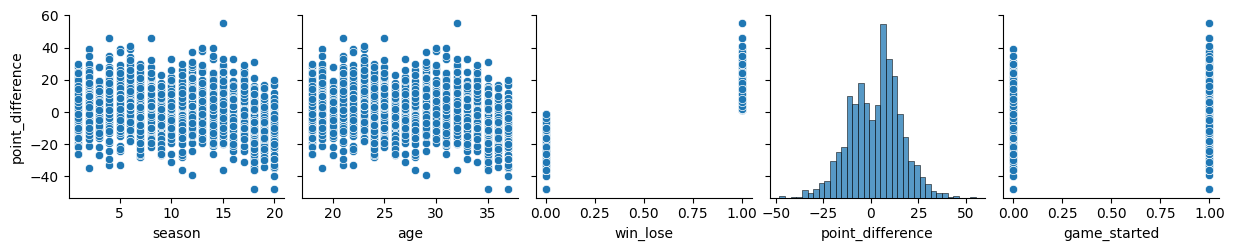

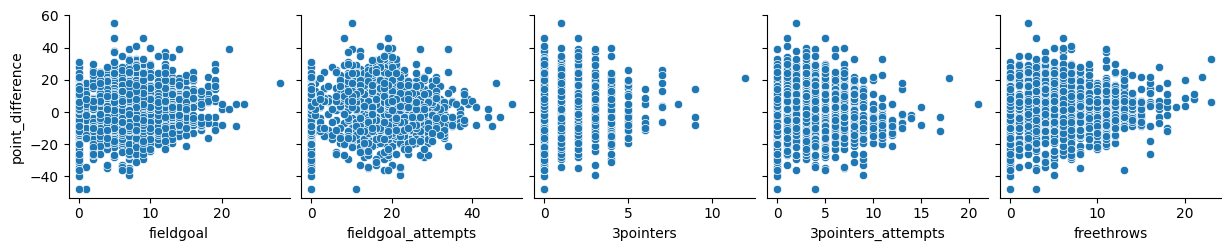

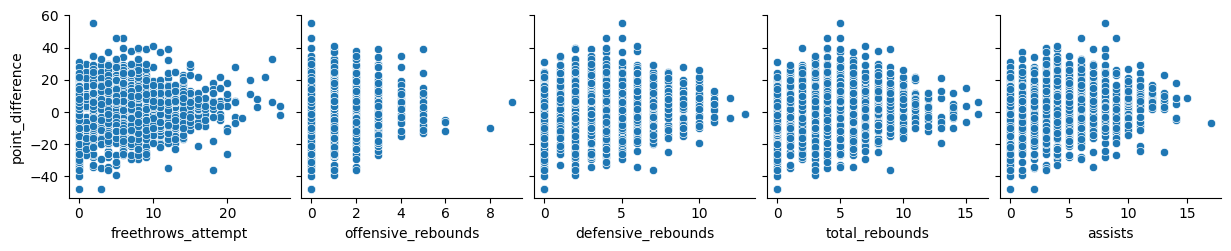

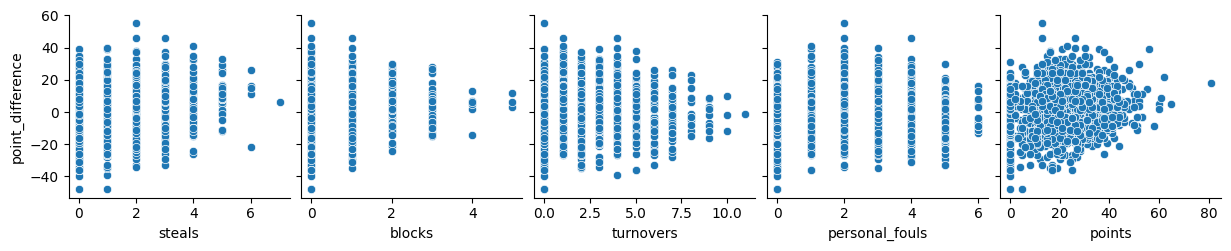

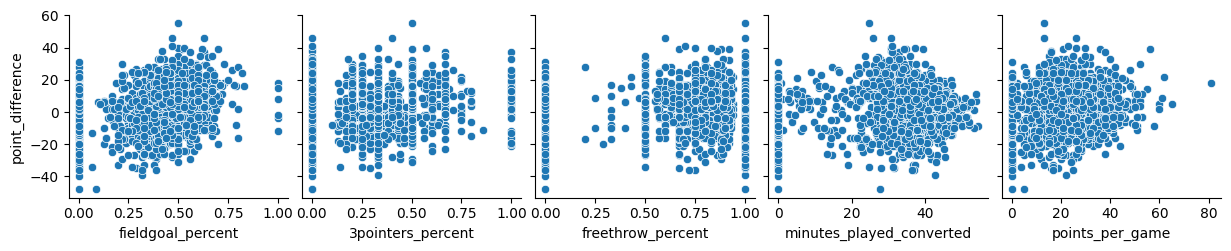

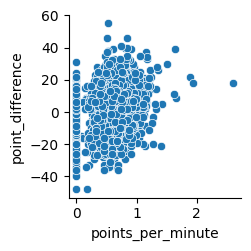

In [20]:
for i in range (0,len(kobe_num.columns), 5):
    sns.pairplot(data=kobe_num,
                 x_vars=kobe_num.columns[i:i+5],
                 y_vars=['point_difference'])

We did not find a strong correlation in any of the variables. This may emerge later, as we normalize the variables. However, it is useful to see if we find stronger correlations by using win_lose as target variable instead of poin_difference. As one of the two will be selected as target_variable, the other will be dropped, since the two variables together would overfit the model.

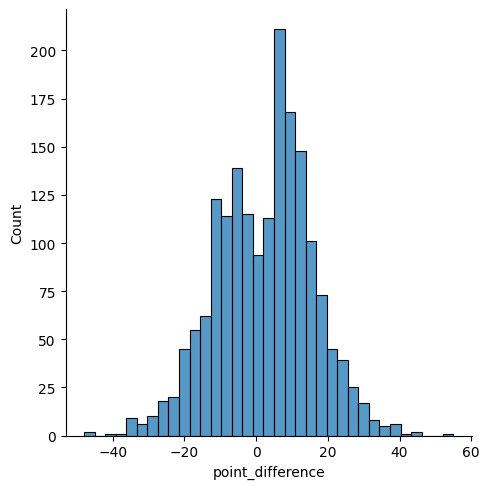

In [21]:
#Let's check the skewweness of our target variable, before we make any prediction. The assumption of the normal distribution must be met in order to perform any type of regression analysis.
pdif_untrasformed = sns.displot(kobe['point_difference'])

In [22]:
print("Skeweness: %f" % kobe['point_difference'].skew())

Skeweness: -0.129433


This skewness is withing the acceptable range of -0.5 to 0.5 for a normal distribution, but it can be improved.

In [23]:
log_transformed_pdif = np.log(kobe['point_difference'])

C:\Users\gabri\AppData\Roaming\Python\Python311\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


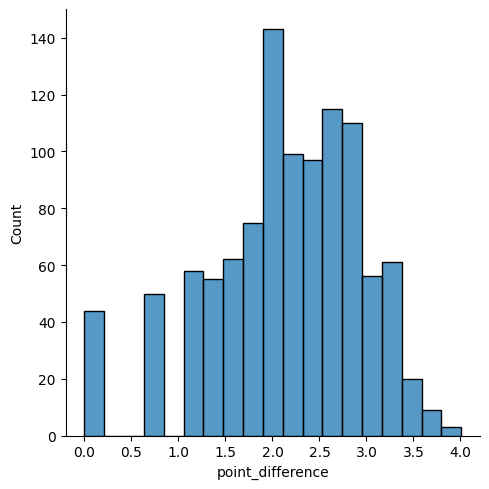

In [24]:
pdif_transformed = sns.displot(log_transformed_pdif)

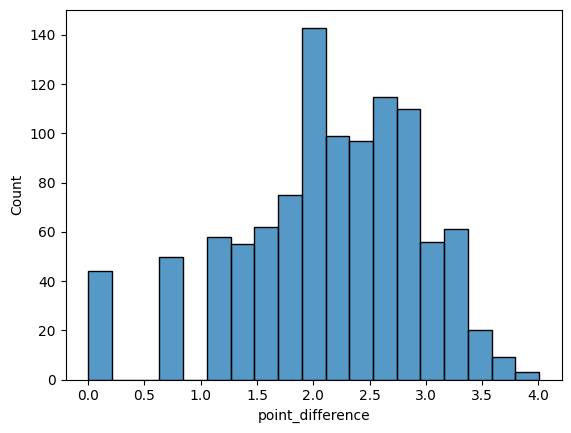

In [25]:
pdif_transformed_2 = sns.histplot(log_transformed_pdif)

In [26]:
print("Skewness: %f" % (log_transformed_pdif).skew())

Skewness: -0.663688


The log transofrmation made the distribution worse, this time. It means that the dinstribution was already pretty low, originally. Let's try some other methods.

In [27]:
#Let's check for duplicates. We are going to do so specifically in the "date" column, since in the NBA there are not two games at the same date.
duplicate = kobe[kobe.duplicated(['date'])]
duplicate

,season,date,age,team_played,game_type,venue,opponent,win_lose,minutes_played,point_difference,...,blocks,turnovers,personal_fouls,points,fieldgoal_percent,3pointers_percent,freethrow_percent,minutes_played_converted,points_per_game,points_per_minute


There are 0 duplicate rows. This is good. If we had any duplicate we would have used kobe.index.is_unique

Text(0.5, 1.0, 'Total Missing Values')

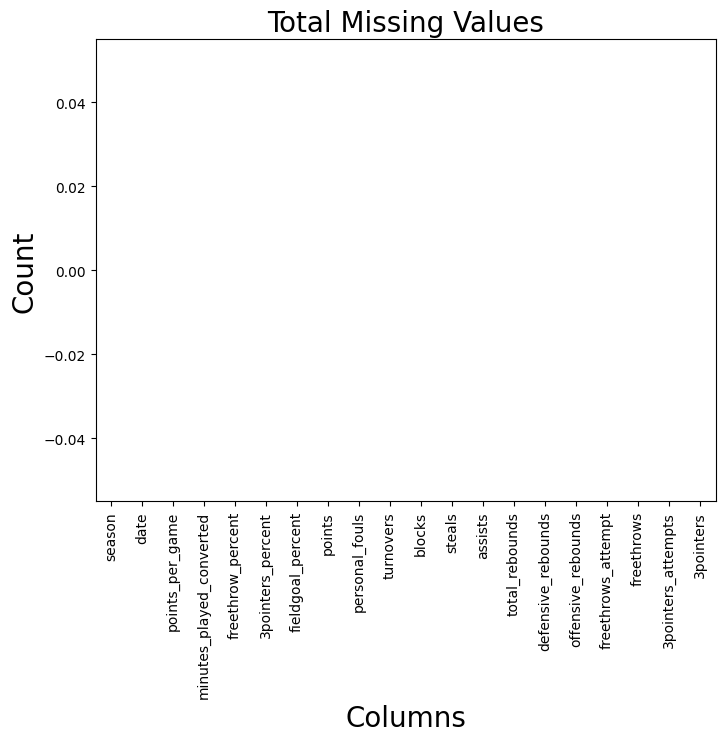

In [28]:
#Now we will see if there is missing value, even if we have already filled the missing values above
total_missing = kobe.isnull().sum().sort_values(ascending=False)
total_missing_select = total_missing.head(20)
total_missing_select.plot(kind="bar", figsize = (8,6), fontsize = 10)

plt.xlabel("Columns", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.title("Total Missing Values", fontsize = 20)

Great! There are not missing values, as expected.

In [30]:
#Now we are going to standardize the values
# Copy the original dataset to avoid modifying it
kobe_standardized = kobe.copy()

# Standardize the values for selected numeric columns
numeric_columns = kobe_num.columns
scaled_values = StandardScaler().fit_transform(kobe_num)

# Create new columns in the new dataset with the standardized values
for i, col in enumerate(numeric_columns):
    kobe_standardized[f'{col}_standardized'] = scaled_values[:, i]

# Display the updated kobe_standardized dataset with new standardized columns
print(kobe_standardized)


      season       date  age         team_played game_type venue  \
0          4  6/19/2000   21  los angeles lakers   playoff  away   
1         14  6/17/2010   31  los angeles lakers   playoff  away   
2         12  6/17/2008   29  los angeles lakers   playoff  home   
3          4  6/16/2000   21  los angeles lakers   playoff  home   
4         14  6/15/2010   31  los angeles lakers   playoff  away   
...      ...        ...  ...                 ...       ...   ...   
1772       1  12/4/1996   18  los angeles lakers    season  home   
1773       1  12/3/1996   18  los angeles lakers    season  away   
1774       1  11/3/1996   18  los angeles lakers    season  away   
1775       1  12/1/1996   18  los angeles lakers    season  away   
1776       1  11/1/1996   18  los angeles lakers    season  away   

                    opponent  win_lose minutes_played  point_difference  ...  \
0              indian pacers         1       44:44:00                 5  ...   
1             boston ce

In [31]:
#Let's view our new kobe_standardized dataset
kobe_standardized.head()

,season,date,age,team_played,game_type,venue,opponent,win_lose,minutes_played,point_difference,...,blocks_standardized,turnovers_standardized,personal_fouls_standardized,points_standardized,fieldgoal_percent_standardized,3pointers_percent_standardized,freethrow_percent_standardized,minutes_played_converted_standardized,points_per_game_standardized,points_per_minute_standardized
0,4,6/19/2000,21,los angeles lakers,playoff,away,indian pacers,1,44:44:00,5,...,2.071641,-0.808856,1.107470,0.303916,-0.475098,0.309859,0.573485,0.871082,0.303205,-0.034472
1,14,6/17/2010,31,los angeles lakers,playoff,away,boston celtics,1,44:51:00,4,...,-0.586342,0.688370,1.107470,0.070495,-0.738514,-0.941031,0.112388,0.879217,0.069590,-0.252279
2,12,6/17/2008,29,los angeles lakers,playoff,home,boston celtics,0,42:46:00,-39,...,-0.586342,0.688370,-1.435132,-1.719069,-0.369731,0.309859,0.890490,0.733946,-0.008282,-1.885230
3,4,6/16/2000,21,los angeles lakers,playoff,home,indian pacers,0,36:44:00,-33,...,-0.586342,-1.307932,1.743120,-1.096612,-1.001930,-0.941031,-1.991370,0.313241,-1.098490,-1.191745
4,14,6/15/2010,31,los angeles lakers,playoff,away,boston celtics,1,39:37:00,22,...,-0.586342,-0.309781,-0.163831,0.303916,0.420517,0.006613,0.890490,0.514296,0.303205,0.204562


Alternatively, we could have used norm_data = MinMaxScaler().fit_transform(hous_num) which is more vulnerable to outliers, or robust scaler which uses the 25 and 75 percentile instead of min and max.

Now it's time to handle outliers. There are outliers that will probably skew our results. For example, we should remove the matches were kobe did not contribute to the final score. We also may want to remove al the matches, when, in the first few seasons Kobe was playing very little, even if he was in a decent team, and the final seasons when the Lakers were not a very competitive team. Let's plot our data to check for outliers and see if we have to remove them.

<Axes: xlabel='minutes_played_converted'>

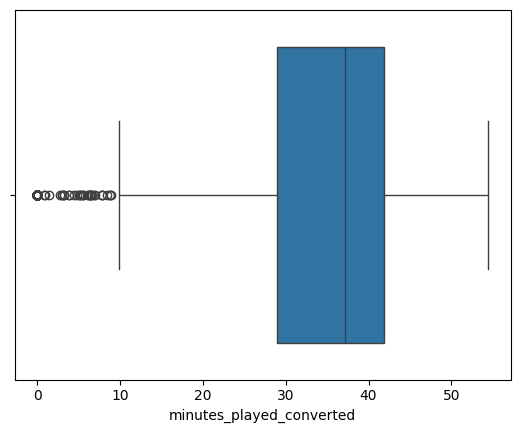

In [32]:
sns.boxplot(x=kobe['minutes_played_converted'])

We still want to understand what is the distribution of the time played, so we can remove outliers and form a normal distribution.

In [33]:
print(np.median(kobe['minutes_played_converted']))

37.166666666666664


In [34]:
print(np.std(kobe['minutes_played_converted']))

14.341001591978616


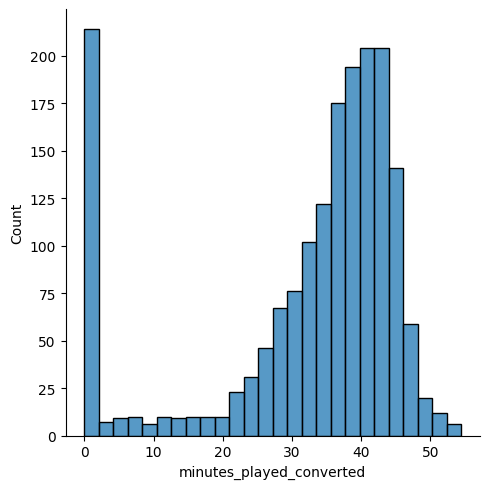

In [35]:
sns.displot(kobe['minutes_played_converted'])

Here we can clearly see that the matches were Kobe played less than 10 minutes are outlier and need to be excluded. Moreover, from the histogram we can see also that from less than 20 minutes we have a long tail thst form a negative skew in the curve.

Here we can see that the games were Kobe did not played or played less than 10 minutes, are skewing the results, so we need to take them out first.

In [36]:
#kobe_enough_playtime = kobe[(kobe['minutes_played_converted'] >= 21) & (kobe['minutes_played_converted'] < 50)]
# Actually, there is no reason to exclude games with more than 50 minutes played, because it means that in those games Kobe had a pivotal role
kobe_enough_playtime = kobe[kobe['minutes_played_converted'] >= 21]
kobe_enough_playtime = kobe_enough_playtime.sort_values(by='season')
kobe_enough_playtime.head()

,season,date,age,team_played,game_type,venue,opponent,win_lose,minutes_played,point_difference,...,blocks,turnovers,personal_fouls,points,fieldgoal_percent,3pointers_percent,freethrow_percent,minutes_played_converted,points_per_game,points_per_minute
1767,1,12/8/1996,18,los angeles lakers,season,away,minnesota timberwolves,1,22:02,24,...,2,3,2,11,0.30,0.00,0.83,22.033333,11,0.499244
82,1,4/30/1997,18,los angeles lakers,playoff,home,portland trailbrazers,0,26:51:00,-8,...,0,4,5,22,0.54,0.67,0.75,26.850000,22,0.819367
1760,1,2/2/1997,18,los angeles lakers,season,away,washington bullets,1,24:00:00,30,...,0,1,0,13,0.22,0.00,1.00,24.000000,13,0.541667
895,1,1/29/1997,18,los angeles lakers,season,home,san antonio spurs,1,29:51:00,7,...,2,3,2,19,0.50,0.43,1.00,29.850000,19,0.636516
495,1,2/19/1997,18,los angeles lakers,season,away,cleveland cavaliers,0,23:27,-19,...,2,1,3,10,0.43,0.50,1.00,23.450000,10,0.426439


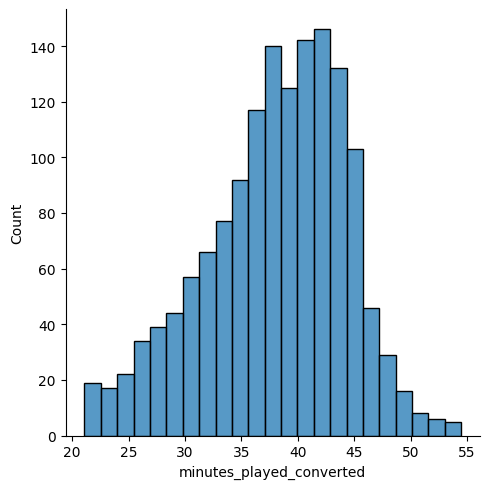

In [37]:
sns.displot(kobe_enough_playtime['minutes_played_converted'])

In [38]:
print("Skeweness: %f" % kobe_enough_playtime['minutes_played_converted'].skew())

Skeweness: -0.435250


The curve as is at the limit, but below the treshold of -0.5, so it can be considered Gaussian. Let's try with using a log tranformation to improve it.

In [39]:
log_transformed_mp = np.log(kobe_enough_playtime['minutes_played_converted'])

In [176]:
print("Skeweness: %f" % log_transformed_mp.skew())

Skeweness: -0.875574


Also, in this case, the log transformation made the situation worse, so we will keep the original curve.

<Axes: xlabel='points'>

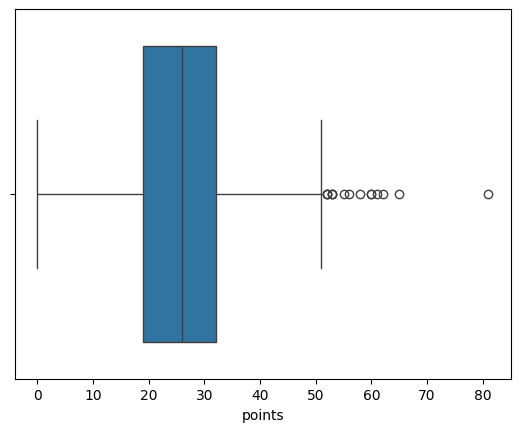

In [40]:
sns.boxplot(x=kobe_enough_playtime['points'])

<Axes: xlabel='minutes_played_converted'>

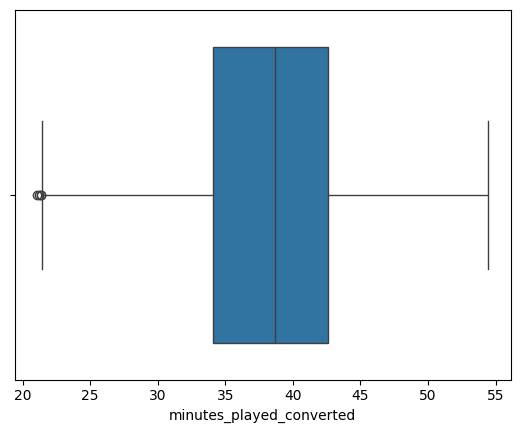

In [41]:
sns.boxplot(x=kobe_enough_playtime['minutes_played_converted'])

Let's double-check if there are games were Kobe did not score any points, to find potential errors.

In [42]:
kobe_no_score = kobe_enough_playtime[kobe_enough_playtime['points'] < 5]
print(kobe_no_score.shape[0])


8


In [43]:
kobe_no_score.iloc[:, :30].head()

,season,date,age,team_played,game_type,venue,opponent,win_lose,minutes_played,point_difference,...,assists,steals,blocks,turnovers,personal_fouls,points,fieldgoal_percent,3pointers_percent,freethrow_percent,minutes_played_converted
108,2,4/26/1998,19,los angeles lakers,playoff,away,portland trailbrazers,1,24:39:00,9,...,4,0,1,1,2,4,0.29,0.00,0.0,24.650000
236,2,3/28/1998,19,los angeles lakers,season,home,utah jazz,0,26:53:00,-15,...,3,4,1,2,1,2,0.00,0.00,1.0,26.883333
1750,2,11/4/1997,19,los angeles lakers,season,home,sacramento kings,1,21:06,3,...,3,2,1,3,1,4,0.20,0.00,0.0,21.100000
2,12,6/17/2008,29,los angeles lakers,playoff,home,boston celtics,0,42:46:00,-39,...,1,1,0,4,0,0,0.32,0.33,1.0,42.766667
1121,17,2/12/2013,34,los angeles lakers,season,away,phoenix suns,1,35:46:00,6,...,9,1,1,8,1,4,0.13,0.00,1.0,35.766667


We spotted an error here, because Kobe score 22 points in the game. The other stats look good, so let's replace "points"

In [44]:
kobe.loc[kobe['date'] == '6/17/2008', 'points'] = 22

In [36]:
#Let's standardize the values again
# Copy the original dataset to avoid modifying it
kobe_standardized = kobe.copy()

# Standardize the values for selected numeric columns
numeric_columns = kobe_num.columns
scaled_values = StandardScaler().fit_transform(kobe_num)

# Create new columns in the new dataset with the standardized values
for i, col in enumerate(numeric_columns):
    kobe_standardized[f'{col}_standardized'] = scaled_values[:, i]

# Display the updated kobe_standardized dataset with new standardized columns
print(kobe_standardized)

      season       date  age         team_played game_type venue  \
0          4  6/19/2000   21  los angeles lakers   playoff  away   
1         14  6/17/2010   31  los angeles lakers   playoff  away   
2         12  6/17/2008   29  los angeles lakers   playoff  home   
3          4  6/16/2000   21  los angeles lakers   playoff  home   
4         14  6/15/2010   31  los angeles lakers   playoff  away   
...      ...        ...  ...                 ...       ...   ...   
1772       1  12/4/1996   18  los angeles lakers    season  home   
1773       1  12/3/1996   18  los angeles lakers    season  away   
1774       1  11/3/1996   18  los angeles lakers    season  away   
1775       1  12/1/1996   18  los angeles lakers    season  away   
1776       1  11/1/1996   18  los angeles lakers    season  away   

                    opponent  win_lose minutes_played  point_difference  ...  \
0              indian pacers         1       44:44:00                 5  ...   
1             boston ce

In [45]:
#Let's update the dataset
kobe_enough_playtime = kobe[kobe['minutes_played_converted'] >= 21]
kobe_enough_playtime = kobe_enough_playtime.sort_values(by='season')
kobe_enough_playtime.head()

,season,date,age,team_played,game_type,venue,opponent,win_lose,minutes_played,point_difference,...,blocks,turnovers,personal_fouls,points,fieldgoal_percent,3pointers_percent,freethrow_percent,minutes_played_converted,points_per_game,points_per_minute
1767,1,12/8/1996,18,los angeles lakers,season,away,minnesota timberwolves,1,22:02,24,...,2,3,2,11,0.30,0.00,0.83,22.033333,11,0.499244
82,1,4/30/1997,18,los angeles lakers,playoff,home,portland trailbrazers,0,26:51:00,-8,...,0,4,5,22,0.54,0.67,0.75,26.850000,22,0.819367
1760,1,2/2/1997,18,los angeles lakers,season,away,washington bullets,1,24:00:00,30,...,0,1,0,13,0.22,0.00,1.00,24.000000,13,0.541667
895,1,1/29/1997,18,los angeles lakers,season,home,san antonio spurs,1,29:51:00,7,...,2,3,2,19,0.50,0.43,1.00,29.850000,19,0.636516
495,1,2/19/1997,18,los angeles lakers,season,away,cleveland cavaliers,0,23:27,-19,...,2,1,3,10,0.43,0.50,1.00,23.450000,10,0.426439


In [46]:
kobe_no_score = kobe_enough_playtime[kobe_enough_playtime['points'] == 0]
print(kobe_no_score.shape[0])

0


That's bettter, but I have some other knowledge I can use. As said before, in the first few years of career, Kobe was did not have enough space in the team, and we partially addressed it Moreover we can also identify and remove the last few years, since the team was not competitive.

Let's plot the win_lose distribution per each season or the point_difference balance per each season.

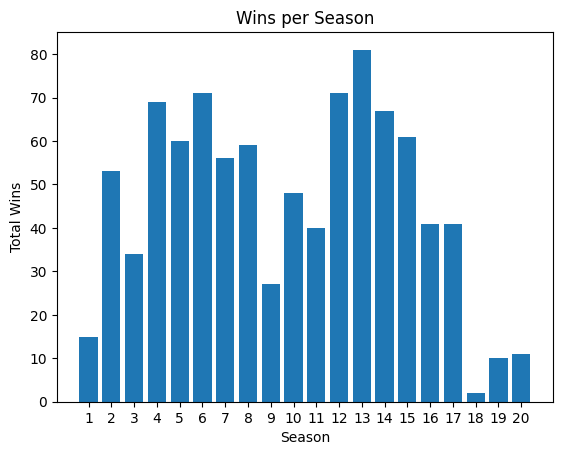

In [47]:
# Group by "season" and sum the "win_lose" column
season_win_lose = kobe_enough_playtime.groupby("season")["win_lose"].sum()

#Plot the bar chart
plt.bar(season_win_lose.index, season_win_lose.values)
plt.xlabel("Season")
plt.ylabel("Total Wins")
plt.title("Wins per Season")

# Set x-axis ticks to show every season
plt.xticks(season_win_lose.index)

plt.show()

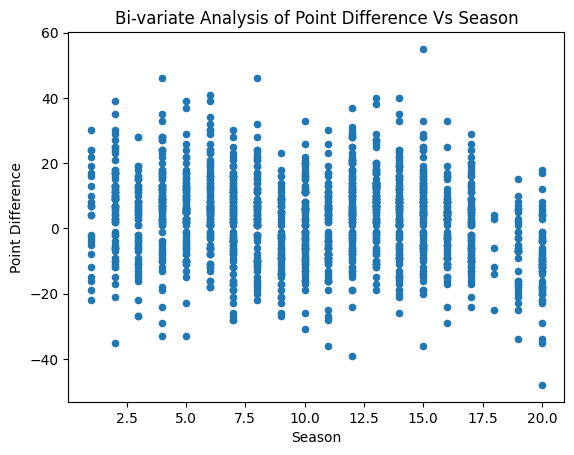

In [48]:
#win_lose_season_bi_variate = kobe_enough_playtime.plot.scatter(
#    x='season', y='point_difference', c='#552583', edgecolors='k', alpha = 1)
#plt.xticks(kobe_enough_playtime['season'].unique())

#Above I've tried to use Lakers purple, but it was terrible as a colour accessibility-wise, so I've decided to stick with the classic blue. 
win_lose_season_bi_variate = kobe_enough_playtime.plot.scatter(
    x='season', y='point_difference')

plt.xlabel("Season")
plt.ylabel("Point Difference")
plt.title("Bi-variate Analysis of Point Difference Vs Season")

plt.show()

We can see that removing the first season and the last 3 seasons makes sense.

In [49]:
kobe_cleaned = kobe_enough_playtime[(kobe_enough_playtime['season'] > 1) & (kobe_enough_playtime['season'] < 18)]

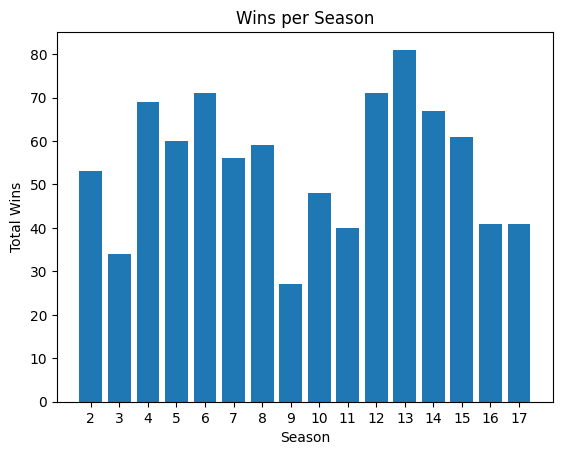

In [42]:
# Group by "season" and sum the "win_lose" column
season_win_lose_cleaned = kobe_cleaned.groupby("season")["win_lose"].sum()

#Plot the bar chart
plt.bar(season_win_lose_cleaned.index, season_win_lose_cleaned.values)
plt.xlabel("Season")
plt.ylabel("Total Wins")
plt.title("Wins per Season")

# Set x-axis ticks to show every season
plt.xticks(season_win_lose_cleaned.index)

plt.show()

Now the datasetdistribution of win and losses looks much smoother.

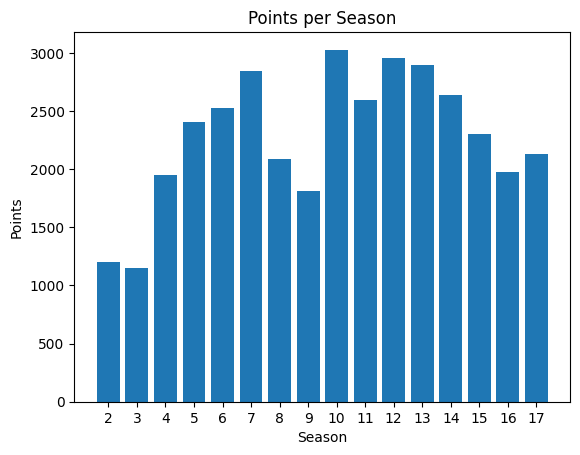

In [50]:
# Group by "season" and sum the "win_lose" column
season_points = kobe_cleaned.groupby("season")["points"].sum()

#Plot the bar chart
plt.bar(season_points.index, season_points.values)
plt.xlabel("Season")
plt.ylabel("Points")
plt.title("Points per Season")

# Set x-axis ticks to show every season
plt.xticks(season_points.index)

plt.show()

In [51]:
print("Skeweness: %f" % season_points.skew())

Skeweness: -0.667846


In [52]:
kobe_cleaned = kobe_cleaned[kobe_cleaned["season"] > 3]
kobe_cleaned.head()

,season,date,age,team_played,game_type,venue,opponent,win_lose,minutes_played,point_difference,...,blocks,turnovers,personal_fouls,points,fieldgoal_percent,3pointers_percent,freethrow_percent,minutes_played_converted,points_per_game,points_per_minute
1655,4,2/4/2000,21,los angeles lakers,season,away,utah jazz,1,25:56:00,46,...,1,4,4,13,0.63,0.00,0.60,25.933333,13,0.501285
389,4,3/13/2000,21,los angeles lakers,season,home,denver nuggets,1,43:26:00,10,...,0,1,4,22,0.40,0.00,0.75,43.433333,22,0.506523
393,4,2/29/2000,21,los angeles lakers,season,home,portland trailbrazers,1,35:45:00,3,...,1,5,4,22,0.55,0.00,1.00,35.750000,22,0.615385
1653,4,6/4/2000,21,los angeles lakers,playoff,away,portland trailbrazers,1,46:57:00,5,...,4,2,4,25,0.47,0.25,0.50,46.950000,25,0.532481
411,4,2/27/2000,21,los angeles lakers,season,away,houston rockets,1,35:59:00,16,...,1,4,5,31,0.72,0.50,0.43,35.983333,31,0.861510


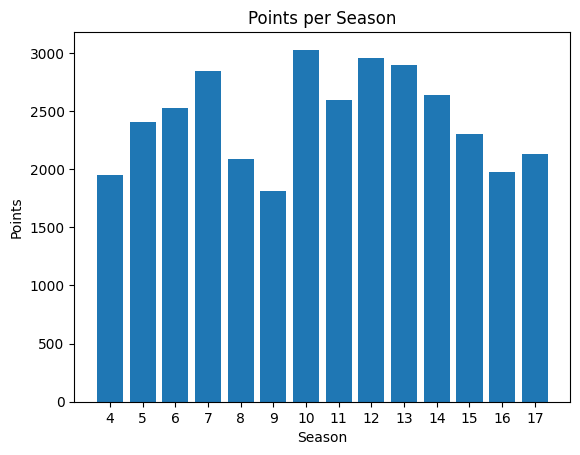

In [53]:
# Group by "season" and sum the "win_lose" column
season_points = kobe_cleaned.groupby("season")["points"].sum()

#Plot the bar chart
plt.bar(season_points.index, season_points.values)
plt.xlabel("Season")
plt.ylabel("Points")
plt.title("Points per Season")

# Set x-axis ticks to show every season
plt.xticks(season_points.index)

plt.show()

In [54]:
print("Skeweness: %f" % season_points.skew())

Skeweness: -0.039003


Much better, the dataset is not skewed anymore!

<Axes: xlabel='points'>

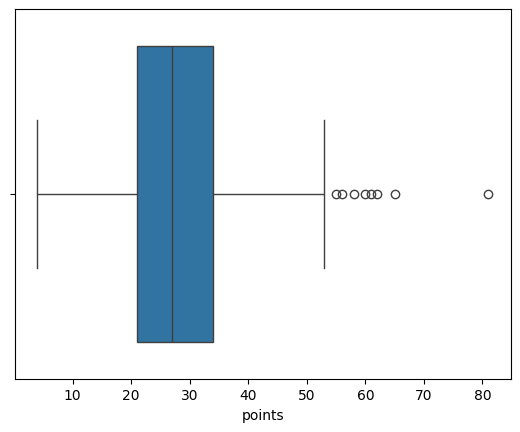

In [55]:
sns.boxplot(x=kobe_cleaned['points'])

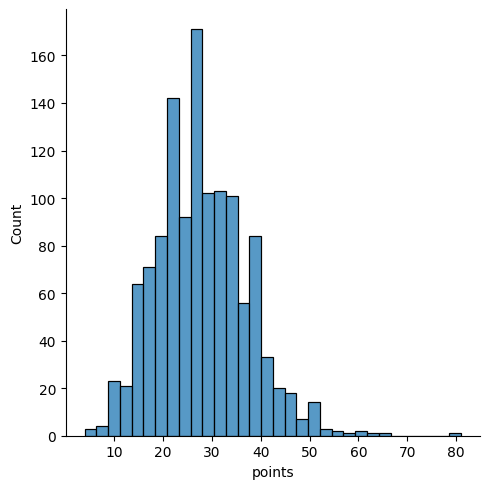

In [56]:
sns.displot(kobe_cleaned['points'])

In [57]:
print("Skeweness: %f" % kobe_cleaned['points'].skew())

Skeweness: 0.553311


<Axes: xlabel='minutes_played_converted'>

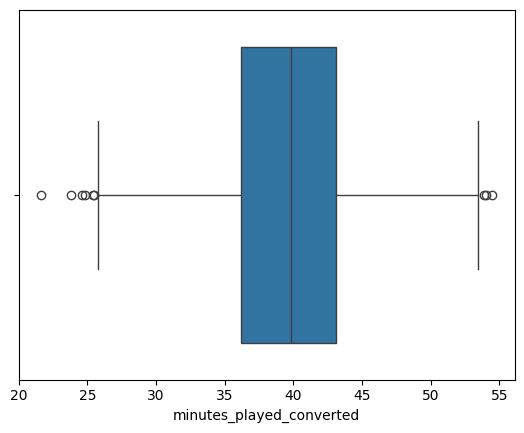

In [58]:
sns.boxplot(x=kobe_cleaned['minutes_played_converted'])

In [59]:
print("Skeweness: %f" % kobe_cleaned['minutes_played_converted'].skew())

Skeweness: -0.290673


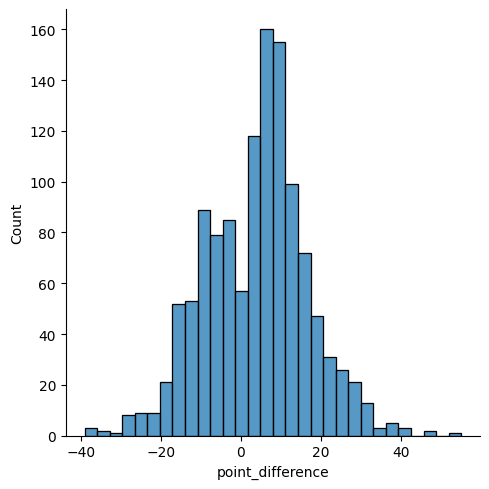

In [60]:
sns.displot(kobe_cleaned['point_difference'])

In [61]:
print("Skeweness: %f" % kobe_cleaned['point_difference'].skew())

Skeweness: -0.005485


<Axes: xlabel='point_difference'>

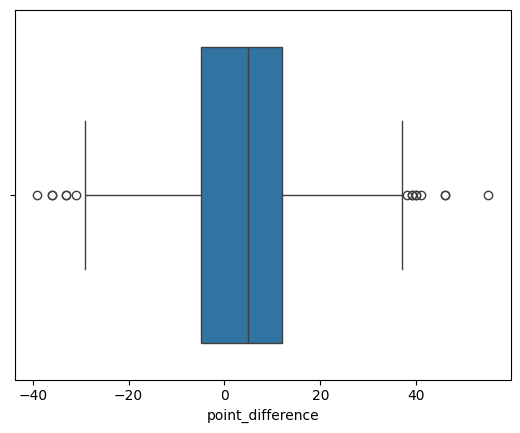

In [62]:
sns.boxplot(x=kobe_cleaned['point_difference'])

We plotted the different variables we are worked with in the cleaning phase, to see their distribution now. They all have a normal distribution apart from the "points" feature. However, since that is not our target feature and since games where Kobe scored abnormally high, were games where is also contributed a lot, we are going to leave them.

Finally, to conclude the data cleaning process, let's check again the correlation between the numeric features in the new datase.

In [63]:
kobe_cleaned_num = kobe_cleaned.select_dtypes(include = ['float64', 'int64'])
kobe_cleaned_num_corr = kobe_cleaned_num.corr()['point_difference'][:-1] # -1 means that the latest row is point_difference
top_features_cleaned = kobe_cleaned_num_corr[abs(kobe_cleaned_num_corr) > 0.1].sort_values(ascending=False) #displays pearsons correlation coefficient greater than 0.5
print("There is {} correlated values with point_difference:\n{}".format(len(top_features_cleaned), top_features_cleaned))

There is 9 correlated values with point_difference:
point_difference            1.000000
win_lose                    0.791563
fieldgoal_percent           0.290657
steals                      0.136961
personal_fouls             -0.136212
turnovers                  -0.165080
3pointers_attempts         -0.203277
fieldgoal_attempts         -0.216450
minutes_played_converted   -0.347054
Name: point_difference, dtype: float64


Let's find outliers in the minutes played, since, when games go in overtime, usually they have a low point difference, they can skew the prediction.

In [64]:
overtime = kobe_cleaned[kobe_cleaned['minutes_played_converted'] > 48]
overtime["minutes_played_converted"].count()

40

In [65]:
#Let's make a dataset that exclude the matches that went overtime, since in those matches usually there is little point difference.
non_overtime = overtime = kobe_cleaned[kobe_cleaned['minutes_played_converted'] <= 48]

In [66]:
#Let's see if the correlation between "point_difference" and "minutes_played_converted" has changed.
non_overtime_num = non_overtime.select_dtypes(include = ['float64', 'int64'])
non_overtime_num_corr = non_overtime_num.corr()['point_difference'][:-1] # -1 means that the latest row is point_difference
top_features_cleaned = non_overtime_num_corr[abs(non_overtime_num_corr) > 0.1].sort_values(ascending=False) #displays pearsons correlation coefficient greater than 0.5
print("There is {} correlated values with point_difference:\n{}".format(len(top_features_cleaned), top_features_cleaned))

There is 10 correlated values with point_difference:
point_difference            1.000000
win_lose                    0.795514
fieldgoal_percent           0.291740
steals                      0.138495
assists                     0.105570
personal_fouls             -0.132477
turnovers                  -0.158810
3pointers_attempts         -0.202534
fieldgoal_attempts         -0.217384
minutes_played_converted   -0.360667
Name: point_difference, dtype: float64


It turns out that the correlation is even more negative this way, so let's still to including the overtime games too.

We see that some other interesing weak correlations came out. It makes sense that field goal percent has a positive correlation. But it's interesing that "points" is not displayed among the correlations and that "minutes_plaued_converted" and "turnovers" have negative correlation with "point_difference"

In [67]:
kobe_cleaned_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1224 entries, 1655 to 1132
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   season                    1224 non-null   int64  
 1   age                       1224 non-null   int64  
 2   win_lose                  1224 non-null   int64  
 3   point_difference          1224 non-null   int64  
 4   game_started              1224 non-null   int64  
 5   fieldgoal                 1224 non-null   int64  
 6   fieldgoal_attempts        1224 non-null   int64  
 7   3pointers                 1224 non-null   int64  
 8   3pointers_attempts        1224 non-null   int64  
 9   freethrows                1224 non-null   int64  
 10  freethrows_attempt        1224 non-null   int64  
 11  offensive_rebounds        1224 non-null   int64  
 12  defensive_rebounds        1224 non-null   int64  
 13  total_rebounds            1224 non-null   int64  
 14  assists   

In [68]:
kobe_cleaned_num.iloc[:, :20].describe()

,season,age,win_lose,point_difference,game_started,fieldgoal,fieldgoal_attempts,3pointers,3pointers_attempts,freethrows,freethrows_attempt,offensive_rebounds,defensive_rebounds,total_rebounds,assists,steals,blocks,turnovers,personal_fouls,points
count,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000
mean,10.455065,27.455065,0.647059,3.903595,0.995915,9.793301,21.555556,1.437092,4.277778,6.877451,8.214052,1.191176,4.494281,5.685458,5.204248,1.569444,0.513889,3.170752,2.700980,27.901144
std,3.978225,3.978225,0.478080,12.765980,0.063809,3.478083,6.212786,1.513946,2.807180,3.996075,4.536210,1.203451,2.319169,2.668048,2.649139,1.294083,0.791287,1.853002,1.372716,9.205789
min,4.000000,21.000000,0.000000,-39.000000,0.000000,1.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
25%,7.000000,24.000000,0.000000,-5.000000,1.000000,7.000000,17.000000,0.000000,2.000000,4.000000,5.000000,0.000000,3.000000,4.000000,3.000000,1.000000,0.000000,2.000000,2.000000,21.000000
50%,11.000000,28.000000,1.000000,5.000000,1.000000,10.000000,21.000000,1.000000,4.000000,6.000000,8.000000,1.000000,4.000000,5.000000,5.000000,1.000000,0.000000,3.000000,3.000000,27.000000
75%,14.000000,31.000000,1.000000,12.000000,1.000000,12.000000,26.000000,2.000000,6.000000,9.000000,11.000000,2.000000,6.000000,7.000000,7.000000,2.000000,1.000000,4.000000,4.000000,34.000000
max,17.000000,34.000000,1.000000,55.000000,1.000000,28.000000,47.000000,12.000000,18.000000,23.000000,27.000000,9.000000,13.000000,16.000000,15.000000,7.000000,5.000000,11.000000,6.000000,81.000000


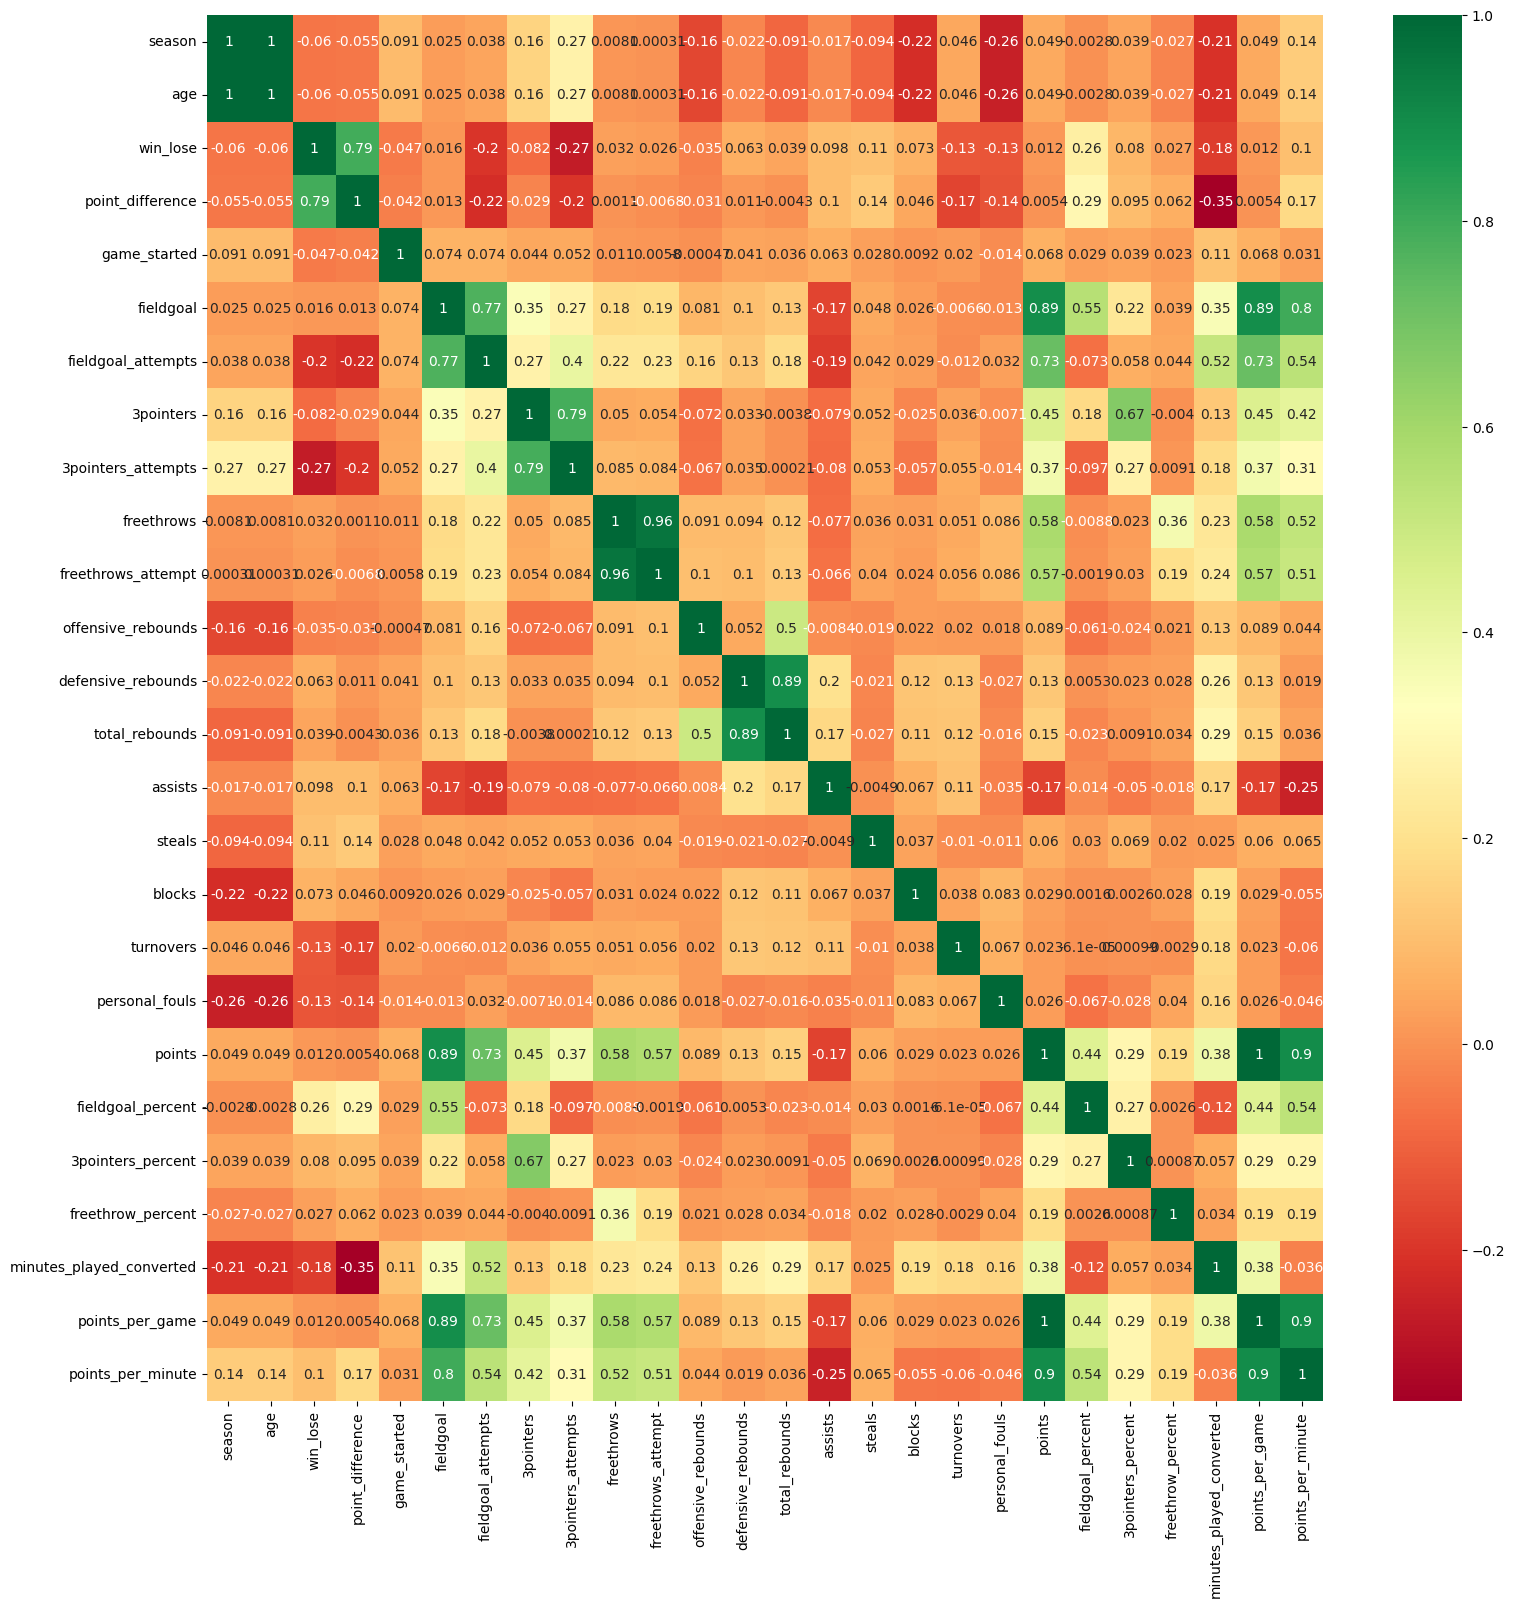

In [69]:
plt.figure(figsize=(18,18))
sns.heatmap(kobe_cleaned_num.corr(),annot=True,cmap='RdYlGn')

plt.show()

<Axes: >

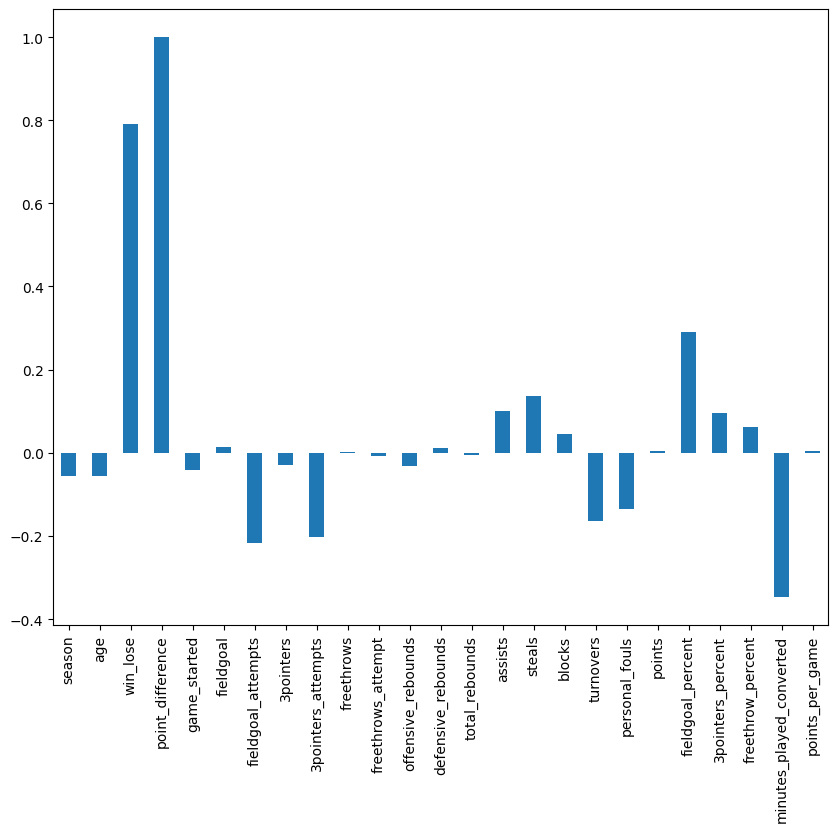

In [70]:
kobe_cleaned_num_corr.plot(kind='bar',figsize=(10,8))

Before going further with PCA, let's standardize the data with RobustScaler, this time.

In [71]:
# Copy the original dataset to avoid modifying it
kobe_standardized_r = kobe_cleaned_num.copy()

# Create a RobustScaler instance and fit_transform the selected numeric columns
numeric_columns = kobe_standardized_r.columns
scaled_values = RobustScaler().fit_transform(kobe_standardized_r)

# Create new columns in the new dataset with the standardized values
for i, col in enumerate(numeric_columns):
    kobe_standardized_r[f'{col}_standardized'] = scaled_values[:, i]

# Display the updated kobe_standardized dataset with new standardized columns
print(kobe_standardized_r)

      season  age  win_lose  point_difference  game_started  fieldgoal  \
1655       4   21         1                46             1          5   
389        4   21         1                10             1          8   
393        4   21         1                 3             1          6   
1653       4   21         1                 5             1          9   
411        4   21         1                16             1         13   
...      ...  ...       ...               ...           ...        ...   
438       17   34         1                 4             1         13   
1143      17   34         0               -17             1          8   
1139      17   34         1                 6             1         14   
576       17   34         0               -12             1         13   
1132      17   34         1                 2             1         11   

      fieldgoal_attempts  3pointers  3pointers_attempts  freethrows  ...  \
1655                   8          0

In [72]:
# Exclude "win_lose" column from features (X) because it would clearly overfit the model
x_columns = kobe_cleaned_num.columns.difference(['win_lose'])

# Extract features (X) and target variable (y)
x = kobe_cleaned_num[x_columns]
y = kobe_cleaned_num['point_difference']

x_scaled =StandardScaler().fit_transform(x.astype(np.float64))
x_scaled

array([[-0.94962359, -1.16811814, -1.12267957, ...,  0.33284698,
        -0.63197755,  0.44769909],
       [-0.94962359, -0.45536809, -1.12267957, ..., -0.44021697,
         1.24281771, -1.17195713],
       [-0.94962359, -1.16811814, -1.12267957, ..., -0.44021697,
         0.4928996 ,  0.9875845 ],
       ...,
       [ 1.03276289,  0.97013201,  0.54226467, ..., -1.21328093,
         0.4928996 ,  1.52746991],
       [ 2.35435387,  1.68288207,  1.04561991, ..., -1.21328093,
        -0.63197755, -0.63207172],
       [ 2.35435387,  2.03925709,  0.81330211, ...,  0.33284698,
         0.11794055,  3.14712614]])

In [73]:
pca = PCA(n_components = 2)
pca.fit_transform(x_scaled)
explained_variance=pca.explained_variance_ratio_
explained_variance

array([0.23190605, 0.11283298])

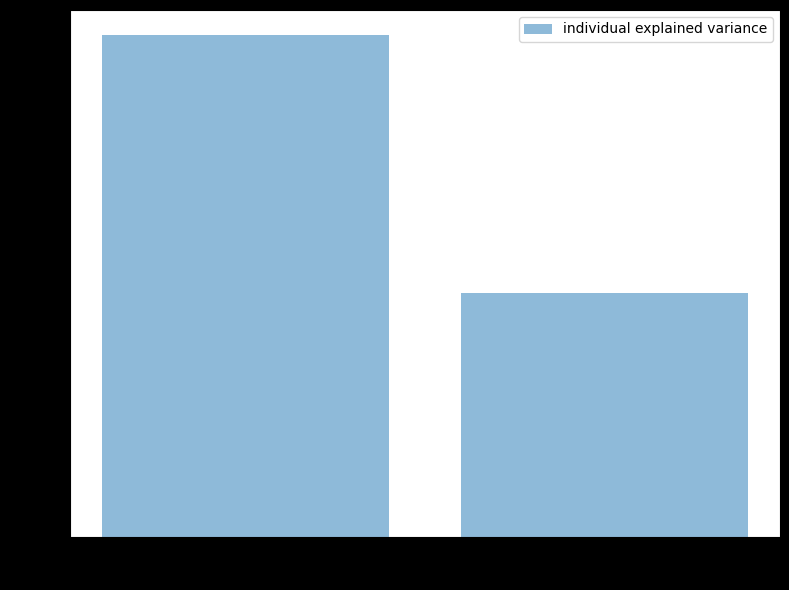

In [74]:
with plt.style.context('dark_background'):
    plt.figure(figsize=(8, 6))

plt.bar(range(2), explained_variance, alpha=0.5, align='center',
label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout() 

In [75]:
#Alternatively, instead to chose the variance manually, we can chose the percentage of variance we want to explain (usually 95%)
pca = PCA(n_components=0.95)
x_reduced = pca.fit_transform(x)
print(x_reduced)

[[-3.47420543e+01  3.81673586e+01 -5.76675538e+00 ... -4.59993934e+00
   1.17909445e+00  2.74328948e-01]
 [-8.59498031e+00  3.82738394e+00 -1.13811689e+01 ...  2.40555146e+00
   3.65346121e-02  2.47838990e+00]
 [-1.14342635e+01 -1.52883579e+00 -7.19725767e+00 ... -4.85740745e+00
   3.84414981e+00  1.28860166e+00]
 ...
 [ 1.96559383e+01  6.32644470e+00  8.19408875e+00 ...  6.01028370e+00
   6.81975603e+00 -4.75582763e+00]
 [ 2.08744330e+01 -1.23455121e+01  9.11537399e+00 ...  1.71278290e+00
   2.34228691e+00 -5.73437047e+00]
 [ 2.02844690e+01  1.84063222e+00  8.04437425e+00 ...  7.63588867e+00
   3.61379888e+00 -6.00017876e+00]]


Earlier, RobustScaler produced more interesting results, whereas StandardScaler, did make the data dinstribution variate from the original dataset. Let's create a dataset by taken the latest dataset and apply robust scaling.

In [76]:
# Copy the original dataset to avoid modifying it
kobe_cleaned_standardized_r = kobe_cleaned_num.copy()

# Create a RobustScaler instance and fit_transform the selected numeric columns
numeric_columns = kobe_cleaned_standardized_r.columns
scaled_values = RobustScaler().fit_transform(kobe_cleaned_standardized_r)

# Create a new dataset with only the standardized columns
kobe_cleaned_standardized_r = pd.DataFrame(scaled_values, columns=[f'{col}_standardized' for col in numeric_columns])

# Display the updated kobe_cleaned_standardized_r dataset with new standardized columns
print(kobe_cleaned_standardized_r)

      season_standardized  age_standardized  win_lose_standardized  \
0               -1.000000         -1.000000                    0.0   
1               -1.000000         -1.000000                    0.0   
2               -1.000000         -1.000000                    0.0   
3               -1.000000         -1.000000                    0.0   
4               -1.000000         -1.000000                    0.0   
...                   ...               ...                    ...   
1219             0.857143          0.857143                    0.0   
1220             0.857143          0.857143                   -1.0   
1221             0.857143          0.857143                    0.0   
1222             0.857143          0.857143                   -1.0   
1223             0.857143          0.857143                    0.0   

      point_difference_standardized  game_started_standardized  \
0                          2.411765                        0.0   
1                          

In [77]:
kobe_cleaned_standardized_r_corr = kobe_cleaned_standardized_r.corr()['point_difference_standardized'][:-1] # -1 means that the latest row is point_difference
top_features_cleaned = kobe_cleaned_standardized_r_corr[abs(kobe_cleaned_standardized_r_corr) > 0.1].sort_values(ascending=False) #displays pearsons correlation coefficient greater than 0.5
print("There is {} correlated values with point_difference:\n{}".format(len(top_features_cleaned), top_features_cleaned))

There is 9 correlated values with point_difference:
point_difference_standardized            1.000000
win_lose_standardized                    0.791563
fieldgoal_percent_standardized           0.290657
steals_standardized                      0.136961
personal_fouls_standardized             -0.136212
turnovers_standardized                  -0.165080
3pointers_attempts_standardized         -0.203277
fieldgoal_attempts_standardized         -0.216450
minutes_played_converted_standardized   -0.347054
Name: point_difference_standardized, dtype: float64


<Axes: >

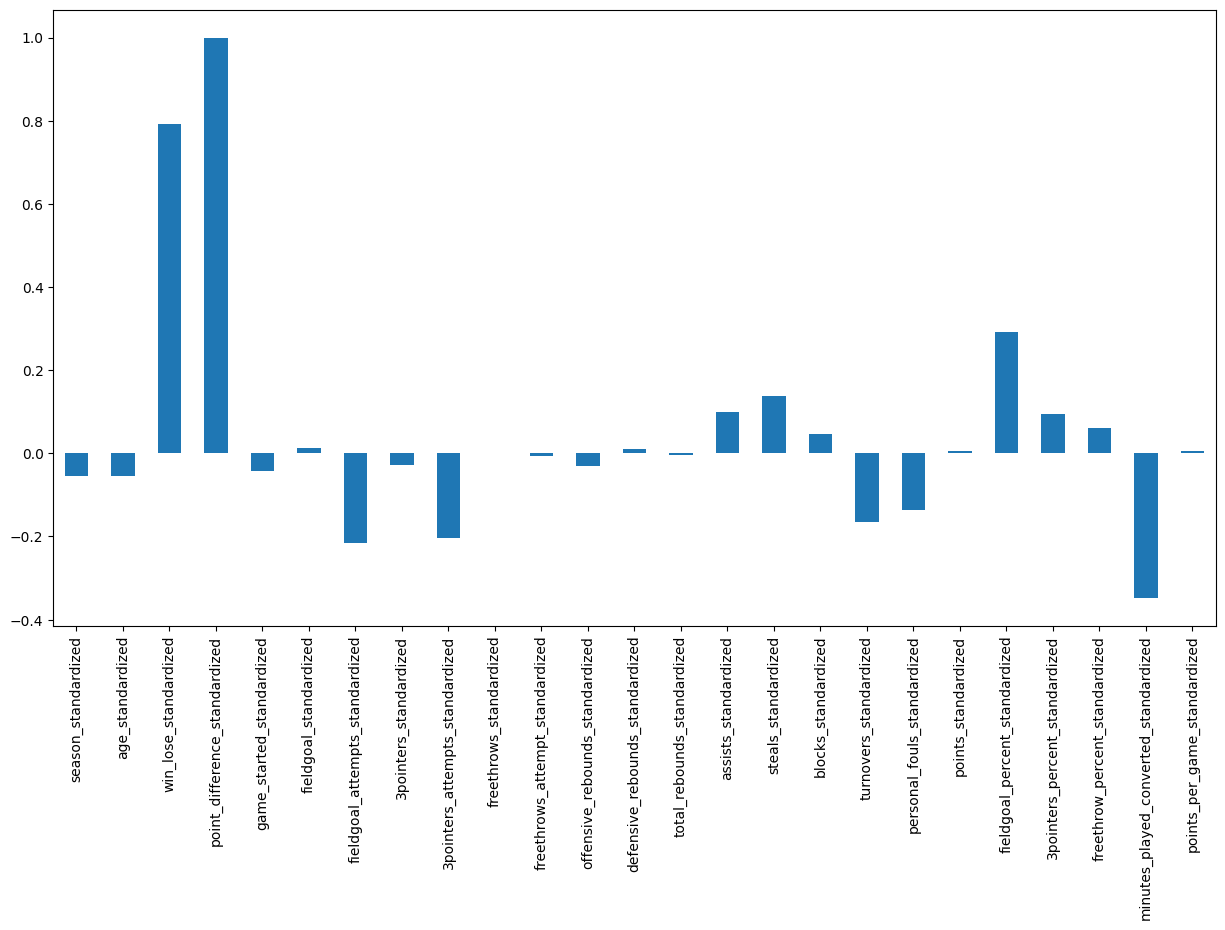

In [78]:
kobe_cleaned_standardized_r_corr.plot(kind='bar',figsize=(15,8))

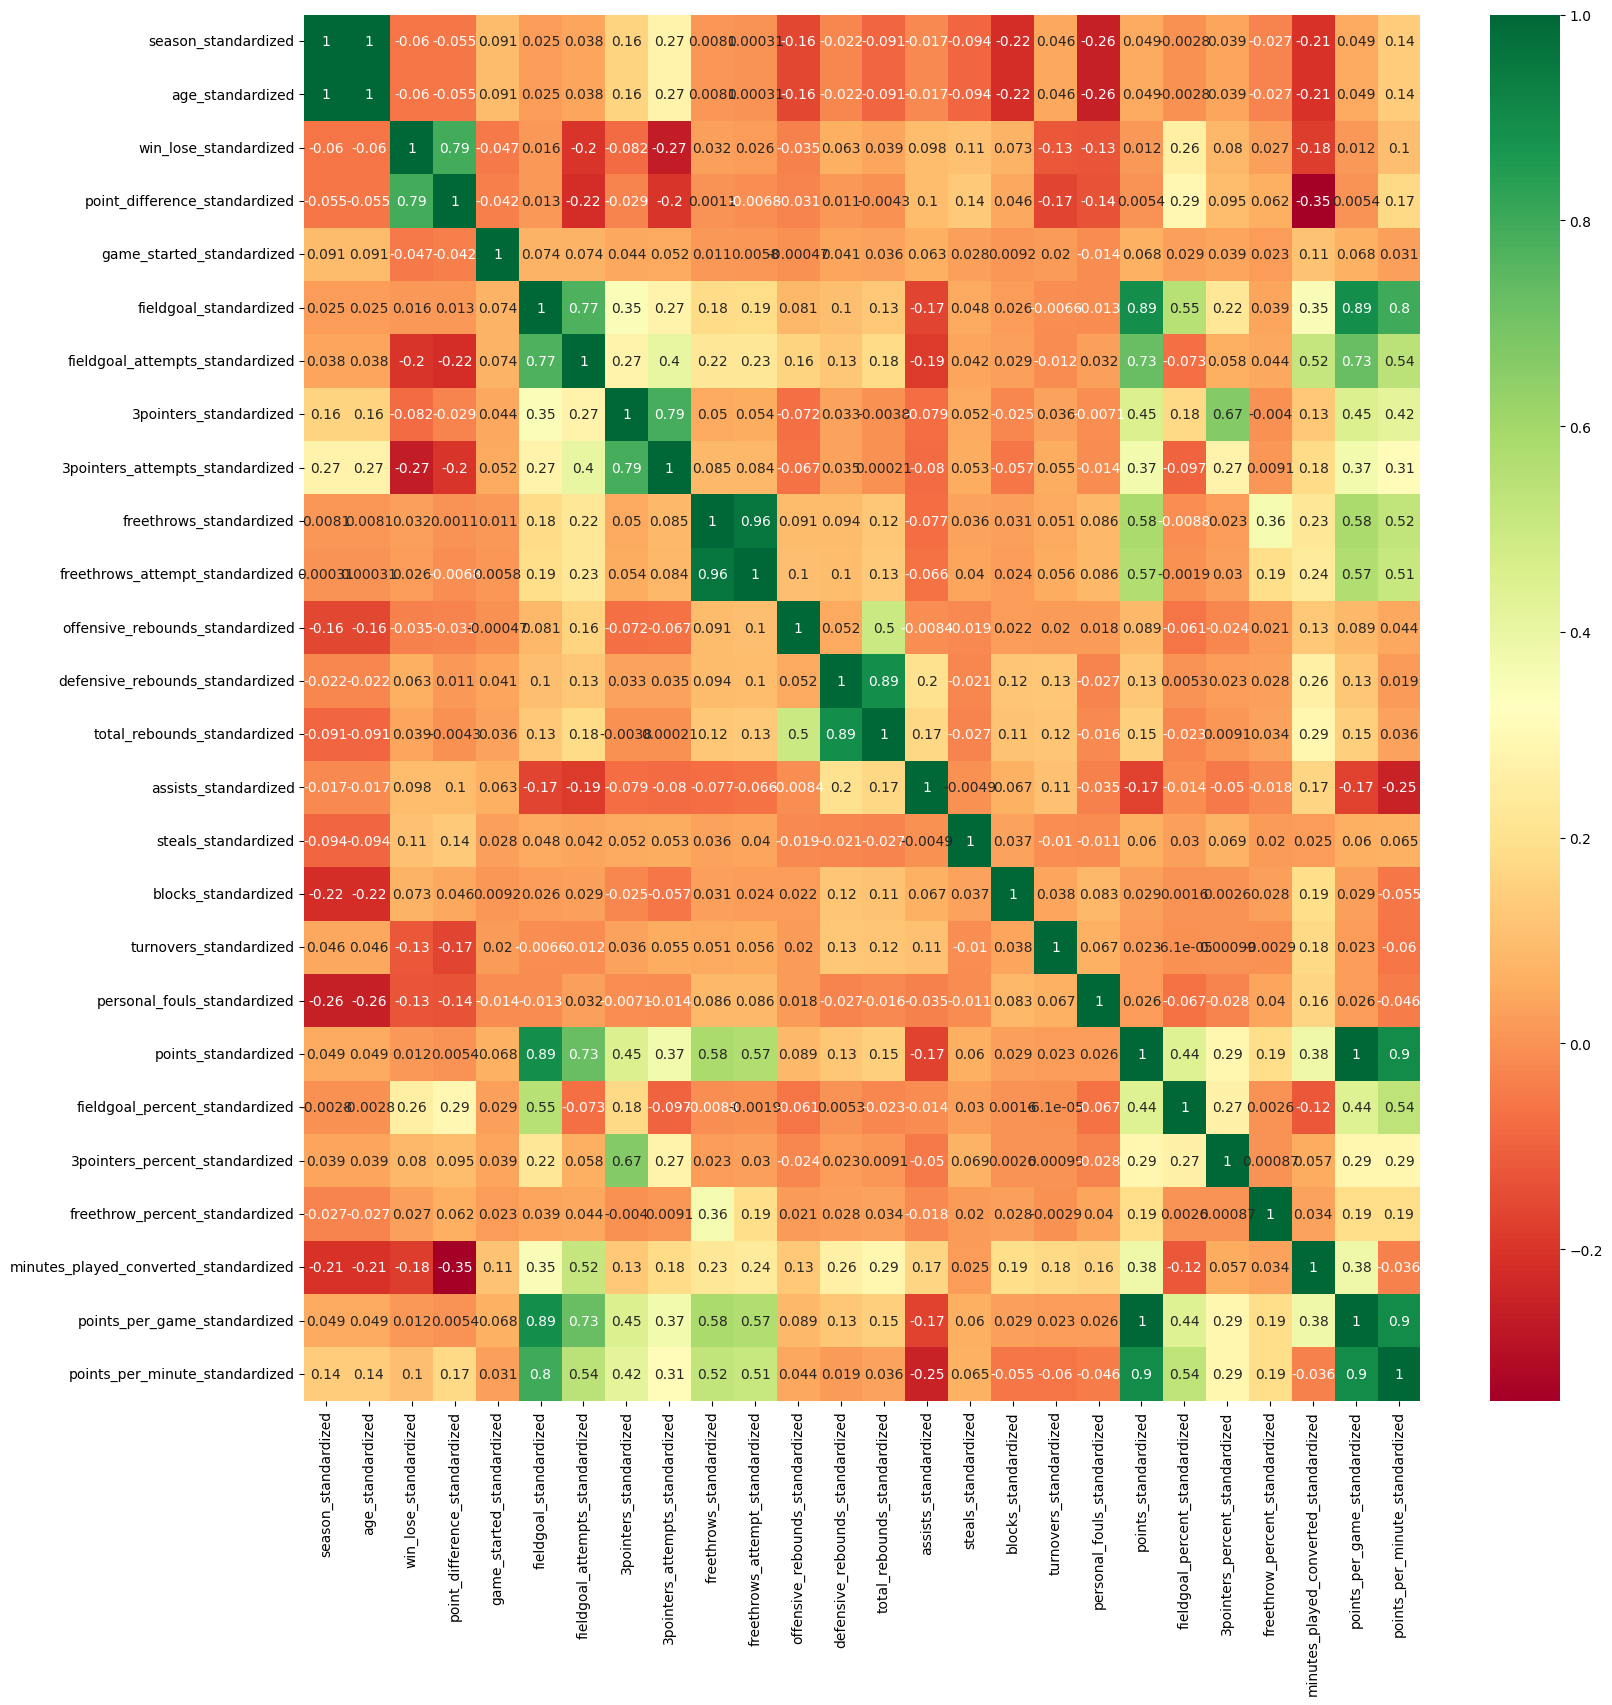

In [79]:
plt.figure(figsize=(18,18))
sns.heatmap(kobe_cleaned_standardized_r.corr(),annot=True,cmap='RdYlGn')

plt.show()

As we can see there is not any difference between the original and the standardized dataset. So we can keep the non-standardized one.

Since we want to see whether Kobe was stronger with #8 or #24, we shall separate our dataset in 2.

In [80]:
kobe_8= kobe_cleaned[kobe_cleaned['season'] < 11]
kobe_24= kobe_cleaned[kobe_cleaned['season'] >= 11]

Let's see how the two dataset correlate with the target variable.

In [81]:
kobe_8_num = kobe_8.select_dtypes(include = ['float64', 'int64'])
kobe_8_num_corr = kobe_8_num.corr()['point_difference'][:-1] # -1 means that the latest row is point_difference
top_features_cleaned = kobe_8_num_corr[abs(kobe_8_num_corr) > 0.1].sort_values(ascending=False) #displays pearsons correlation coefficient greater than 0.5
print("There is {} correlated values with point_difference:\n{}".format(len(top_features_cleaned), top_features_cleaned))

There is 16 correlated values with point_difference:
point_difference            1.000000
win_lose                    0.790381
fieldgoal_percent           0.380439
3pointers_percent           0.118574
steals                      0.115942
freethrow_percent           0.109139
fieldgoal                   0.106068
points                      0.100188
points_per_game             0.100188
fieldgoal_attempts         -0.152229
personal_fouls             -0.153503
turnovers                  -0.174761
age                        -0.182200
season                     -0.182200
3pointers_attempts         -0.186760
minutes_played_converted   -0.349137
Name: point_difference, dtype: float64


In [82]:
kobe_24_num = kobe_24.select_dtypes(include = ['float64', 'int64'])
kobe_24_num_corr = kobe_24_num.corr()['point_difference'][:-1] # -1 means that the latest row is point_difference
top_features_cleaned = kobe_24_num_corr[abs(kobe_24_num_corr) > 0.1].sort_values(ascending=False) #displays pearsons correlation coefficient greater than 0.5
print("There is {} correlated values with point_difference:\n{}".format(len(top_features_cleaned), top_features_cleaned))

There is 10 correlated values with point_difference:
point_difference            1.000000
win_lose                    0.793023
fieldgoal_percent           0.206716
steals                      0.160516
assists                     0.136391
personal_fouls             -0.124977
turnovers                  -0.155740
3pointers_attempts         -0.229704
fieldgoal_attempts         -0.285082
minutes_played_converted   -0.363400
Name: point_difference, dtype: float64


We can see that with kobe_24 fieldgoal_percent and points have a lower correlation on point_difference, whereas assists and steals a higher correlation. This can be in line with the fact that Kobe used to be more collaborative player later in his career. Moreover, minutes_played_converted have negative correlation, and this can mean two thins. It may be that Kobe was taking too many shots attempts compared to his teammates, and he should have played less. But it also could mean that, the games where he played more, were also the more challenging games, so he had to play the whole game. Another significate could be that if he played more, it means that the team used to have fewer stars or strong players that could add weight to the final score. To add on the latest point, as Kobe used to say, a team with only one or two key players cannot win a championship, as it gets easy to double team and isolate the player, and also the strain that the playoffs and regular season have on the player can exaust him and even lead to injuries.

However, there is a much simpler way of dividing the kobe_cleaned dataset between #8 and #24.

In [83]:
kobe_cleaned['shirt_number'] = np.where(kobe_cleaned['season'] < 11, 8, 24)
kobe_cleaned.head(-5)

,season,date,age,team_played,game_type,venue,opponent,win_lose,minutes_played,point_difference,...,turnovers,personal_fouls,points,fieldgoal_percent,3pointers_percent,freethrow_percent,minutes_played_converted,points_per_game,points_per_minute,shirt_number
1655,4,2/4/2000,21,los angeles lakers,season,away,utah jazz,1,25:56:00,46,...,4,4,13,0.63,0.00,0.60,25.933333,13,0.501285,8
389,4,3/13/2000,21,los angeles lakers,season,home,denver nuggets,1,43:26:00,10,...,1,4,22,0.40,0.00,0.75,43.433333,22,0.506523,8
393,4,2/29/2000,21,los angeles lakers,season,home,portland trailbrazers,1,35:45:00,3,...,5,4,22,0.55,0.00,1.00,35.750000,22,0.615385,8
1653,4,6/4/2000,21,los angeles lakers,playoff,away,portland trailbrazers,1,46:57:00,5,...,2,4,25,0.47,0.25,0.50,46.950000,25,0.532481,8
411,4,2/27/2000,21,los angeles lakers,season,away,houston rockets,1,35:59:00,16,...,4,5,31,0.72,0.50,0.43,35.983333,31,0.861510,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1142,17,4/5/2013,34,los angeles lakers,season,away,memphis grizzlies,1,42:32:00,2,...,4,3,24,0.44,0.00,1.00,42.533333,24,0.564263,24
608,17,12/22/2012,34,los angeles lakers,season,home,golden state warriors,1,43:39:00,3,...,3,5,34,0.39,0.25,0.00,43.650000,34,0.778923,24
585,17,12/25/2012,34,los angeles lakers,season,away,new york knicks,1,43:37:00,6,...,1,2,34,0.58,0.20,0.71,43.616667,34,0.779519,24
1140,17,1/6/2013,34,los angeles lakers,season,away,denver nuggets,0,42:12:00,-7,...,2,2,29,0.42,0.38,1.00,42.200000,29,0.687204,24


Before proceding to formulating an hipothesis, let's save all the datasets into pickle files, so we can access them later without having to run all the code.

In [84]:
kobe.to_pickle('kobe.pkl')
kobe_num.to_pickle('kobe_num')
kobe_enough_playtime.to_pickle('kobe_enough_playtime.pkl')

kobe_cleaned.to_pickle('kobe_cleaned.pkl')
kobe_cleaned_num.to_pickle('kobe_cleaned_num.pkl')

kobe_8.to_pickle('kobe_8.pkl')
kobe_24.to_pickle('kobe_24.pkl')
kobe_8_num.to_pickle('kobe_8_num.pkl')
kobe_24_num.to_pickle('kobe_24_num.pkl')

kobe_cleaned_standardized_r.to_pickle('kobe_cleaned_standardized_r.pkl')

In [85]:
#When we need the differente dataset, we just need to call the following.
kobe = pd.read_pickle('kobe.pkl')
kobe_num = pd.read_pickle('kobe_num')
kobe_enough_playtime = pd.read_pickle('kobe_enough_playtime.pkl')

kobe_cleaned = pd.read_pickle('kobe_cleaned.pkl')
kobe_cleaned_num = pd.read_pickle('kobe_cleaned_num.pkl')

kobe_8 = pd.read_pickle('kobe_8.pkl')
kobe_24 = pd.read_pickle('kobe_24.pkl')
kobe_8_num = pd.read_pickle('kobe_8_num.pkl')
kobe_24_num = pd.read_pickle('kobe_24_num.pkl')

kobe_cleaned_standardized_r = pd.read_pickle('kobe_cleaned_standardized_r.pkl')

H0: m1 - m2 = 0 There is no difference in the influence on point_difference between the games Kobe played with number 8 compared to number 24
HA: m1 - m2 > 0 The is more influence toward a positive point difference from Kobe, when he wore number 8

We will choose 5% significance level (alpha = 0.05). Since we have a one-tailed test, we do not have to divide alpha by 2. So, if the calculated p-value is less than alpha, we will reject the null hypothesis. We can use a z-test since n > 30 and we can easily calculate the standard deviation of the population.

With the same logic we also want to add additional null hypothesis regarding the features that influence point_difference in both datasets. The hypothesis state that there is no difference bewteen number_8 and number_24 for what concerns fielgoal_percent, steals, fieldgoal_attempts, 3pointers_attempts, minutes_played_converted, with the alternative hypothesis stating that there is a difference (a different alternative hypothesis per each feature). In these gases, since we are dealing with a two-tailed test, we need to divide alpha by 2.

H0: m1 - m2 = 0
H0: m1 - m2 != 0

Let's graphycally display the "point_differences" of the two Kobe datasets, and successively, also fieldgoal percent.

In [86]:
#We shall divide the kobe_cleaned dataset between #8 and #24
number_8 = kobe_cleaned.loc[kobe_cleaned.shirt_number==8]
number_24 = kobe_cleaned.loc[kobe_cleaned.shirt_number==24]

In [87]:
#Now let's select the point_difference
pdif_8 = number_8.point_difference
pdif_24 = number_24.point_difference

# Even if not necessary, let's do the same also for "fieldgoal_percent" since it seems to be one of the driver of "point_difference".
#Even if a correlation between 0.39 and 0.20 seems small, considering that there are more than 5 players influencing the score of a game, the correlation is actually stronger than we may think.
fgpr_8 = number_8.fieldgoal_percent
fgpr_24 = number_8.fieldgoal_percent

In [88]:
print("Skeweness: %f" % pdif_8.skew())

Skeweness: -0.022612


In [89]:
print("Skeweness: %f" % pdif_24.skew())

Skeweness: 0.012487


In [90]:
print("Skeweness: %f" % fgpr_8.skew())

Skeweness: 0.103564


In [91]:
print("Skeweness: %f" % fgpr_24.skew())

Skeweness: 0.103564


All datasets are normally distributed.

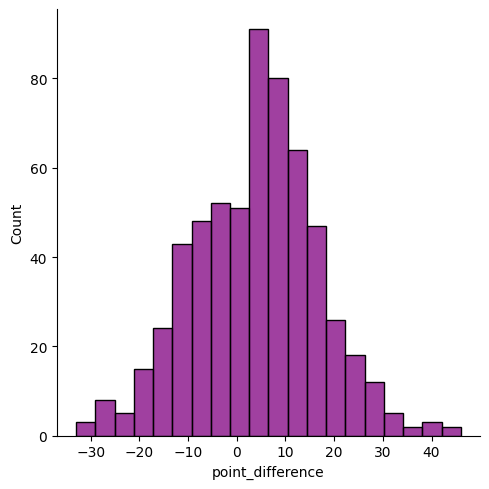

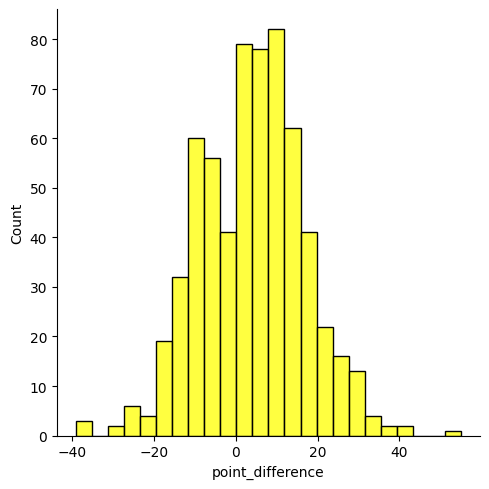

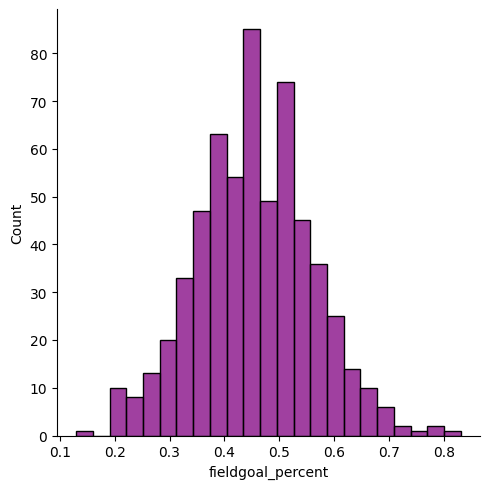

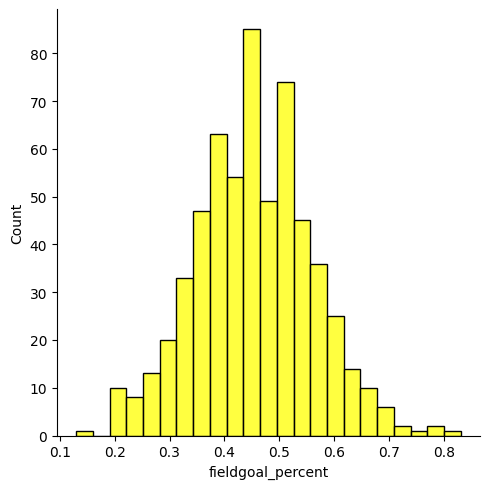

In [92]:
sns.displot(pdif_8,color='purple')
sns.displot(pdif_24,color='yellow')
sns.displot(fgpr_8,color='purple')
sns.displot(fgpr_24,color='yellow')

The distributions are very similar, now let's calculate the mean values of each.

In [93]:
number_8.point_difference.mean()

3.9031719532554257

In [94]:
number_24.point_difference.mean()

3.904

In [95]:
number_8.fieldgoal_percent.mean()

0.45358931552587656

In [96]:
number_24.fieldgoal_percent.mean()

0.460192

It looks that both point_difference and fieldgoal_percent are very similar, but there is a tiny increment in the field_goal percent in number_24. We shall now run a Z-test on both the comparisons.

Furthermore, let's analyse the distribution of steals, fieldgoal_attempts, 3pointers_attempts, minutes_played_converted, since they are all features contributing to point_difference.

In [97]:
#Now let's select the point_difference
steals_8 = number_8.steals
steals_24 = number_24.steals

fga_8 = number_8.fieldgoal_attempts
fga_24 = number_24.fieldgoal_attempts

#Here we use a different method because the column name starts as a number
atm3_8 = number_8["3pointers_attempts"]
atm3_24 = number_24["3pointers_attempts"]


mn_8 = number_8.minutes_played_converted
mn_24 = number_24.minutes_played_converted


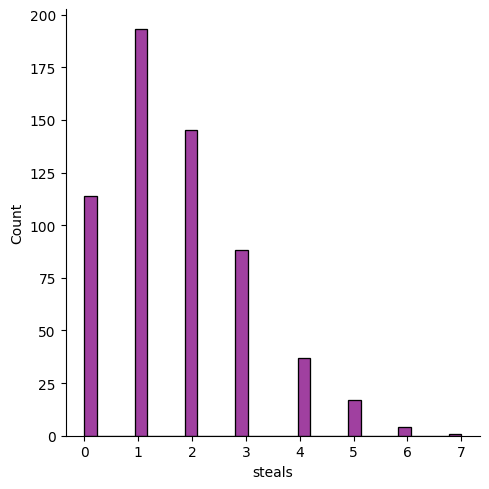

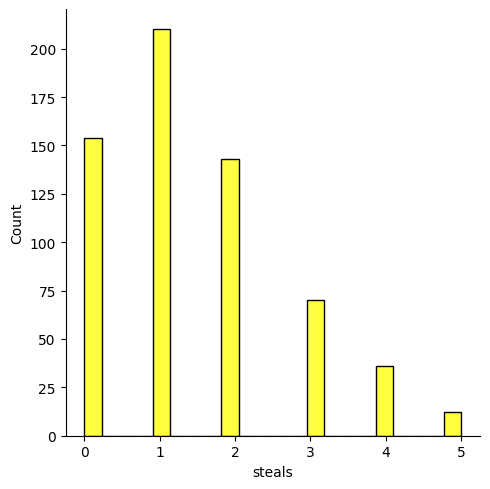

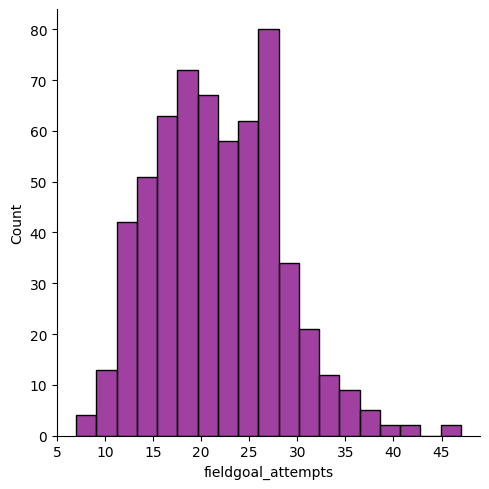

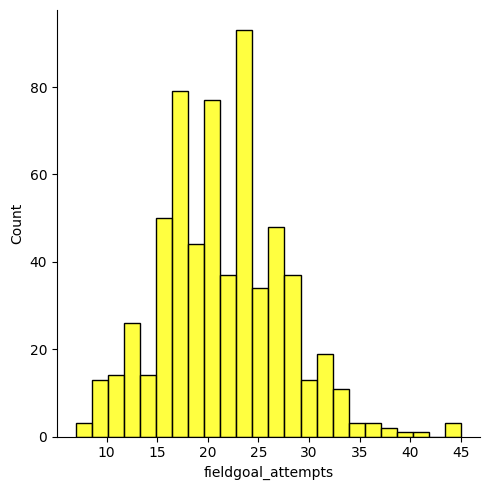

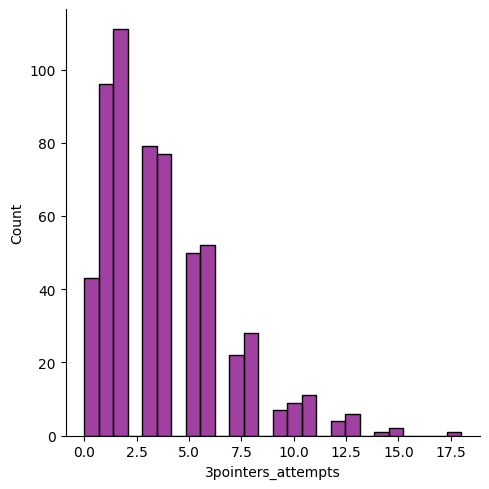

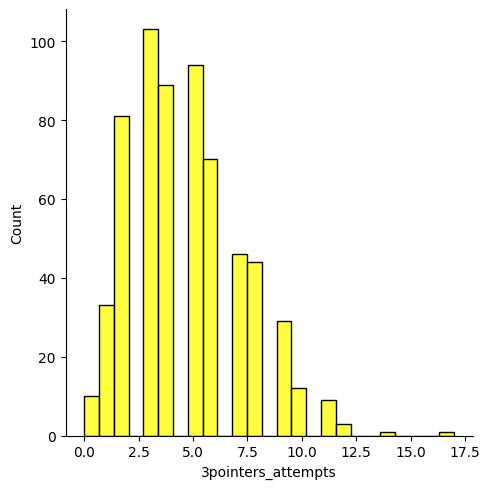

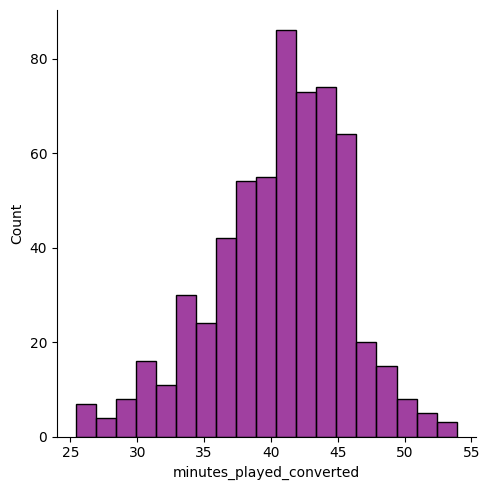

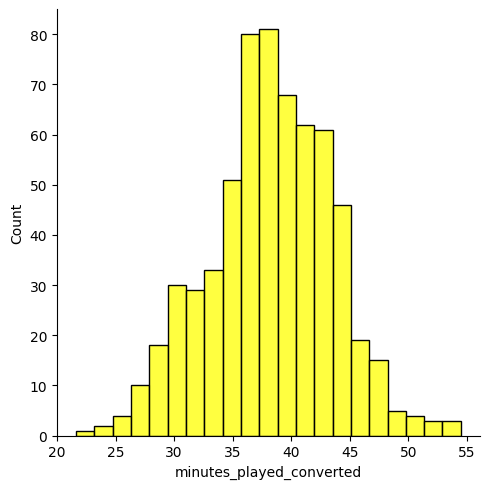

In [98]:
sns.displot(steals_8,color='purple')
sns.displot(steals_24,color='yellow')
sns.displot(fga_8,color='purple')
sns.displot(fga_24,color='yellow')
sns.displot(atm3_8,color='purple')
sns.displot(atm3_24,color='yellow')
sns.displot(mn_8,color='purple')
sns.displot(mn_24,color='yellow')

In [99]:
print("Skeweness: %f" % steals_8.skew())

Skeweness: 0.799338


In [100]:
print("Skeweness: %f" % steals_24.skew())

Skeweness: 0.764989


The distribution of steals is not a normal one.

In [101]:
print("Skeweness: %f" % fga_8.skew())

Skeweness: 0.487124


In [102]:
print("Skeweness: %f" % fga_24.skew())

Skeweness: 0.392937


Fiealdgoal attempts are normally distributed in both groups.

In [103]:
print("Skeweness: %f" % atm3_8.skew())

Skeweness: 1.246307


In [104]:
print("Skeweness: %f" % atm3_24.skew())

Skeweness: 0.670733


The distribution of 3pointers_attempt is not a normal one.

In [105]:
print("Skeweness: %f" % mn_8.skew())

Skeweness: -0.492841


In [106]:
print("Skeweness: %f" % mn_24.skew())

Skeweness: -0.107169


The distribution of minutes_played_converted is normally distributed in both groups.

In [107]:
from statsmodels.stats.weightstats import ztest as ztest_ind

In [108]:
alpha=0.05
z_stat1, p_value1 = ztest_ind(pdif_8, pdif_24)
print("z_stat1 = ", z_stat1, ", p_value1 = ", p_value1)
p_value1_one_tail = p_value1/2
print("p_value1_one_tail = ", p_value1_one_tail)

z_stat1 =  -0.0011339287447190698 , p_value1 =  0.9990952559554239
p_value1_one_tail =  0.49954762797771196


In [109]:
if p_value1 < alpha:
    print("Conclusion: since p_value1_one_tail {} is less than alpha {} ". format (p_value1_one_tail,alpha))
    print("Reject the null hypothesis that there is no difference between point_difference in number_8 and number_24.")

else:
    print("Conclusion: since p_value1_one_tail {} is greather than alpha {} ". format (p_value1_one_tail,alpha))
    print("Fail to reject the null hypothesis that there is point_difference in number_8 and number_24.")

Conclusion: since p_value1_one_tail 0.49954762797771196 is greather than alpha 0.05 
Fail to reject the null hypothesis that there is point_difference in number_8 and number_24.


In [110]:
alpha=0.05
z_stat2, p_value2 = ztest_ind(fgpr_8, fgpr_24)
print("z_stat2 = ", z_stat2, ", p_value2 = ", p_value2)

z_stat2 =  0.0 , p_value2 =  1.0


In [111]:
if p_value2 < alpha:
    print("Conclusion: since p_value2 {} is less than alpha {} ". format (p_value2,alpha))
    print("Reject the null hypothesis that there is no difference between fieldgoal_percentage in number_8 and number_24.")

else:
    print("Conclusion: since p_value2 {} is greather than alpha {} ". format (p_value2,alpha))
    print("Fail to reject the null hypothesis that there is fieldgoal_percentage in number_8 and number_24.")

Conclusion: since p_value2 1.0 is greather than alpha 0.05 
Fail to reject the null hypothesis that there is fieldgoal_percentage in number_8 and number_24.


Let's run a z-test also on fieldgoal_attempts and minutes_played_converted.

In [112]:
fga_mean = fga_8.mean()
print("The mean of fga_8 is: ",fga_mean)

The mean of fga_8 is:  21.65108514190317


In [113]:
fga_mean = fga_24.mean()
print("The mean of fga_24 is: ",fga_mean)

The mean of fga_24 is:  21.464


In [114]:
alpha=0.05
z_stat3, p_value3 = ztest_ind(fga_8, fga_24)
print("z_stat3 = ", z_stat3, ", p_value3 = ", p_value3)

z_stat3 =  0.526486498745259 , p_value3 =  0.5985502302651938


In [115]:
if p_value3 < alpha:
    print("Conclusion: since p_value3 {} is less than alpha {} ". format (p_value3,alpha))
    print("Reject the null hypothesis that there is no difference between fieldgoal_attempts in number_8 and number_24.")

else:
    print("Conclusion: since p_value3 {} is greather than alpha {} ". format (p_value3,alpha))
    print("Fail to reject the null hypothesis that there is fieldgoal_attempts in number_8 and number_24.")

Conclusion: since p_value3 0.5985502302651938 is greather than alpha 0.05 
Fail to reject the null hypothesis that there is fieldgoal_attempts in number_8 and number_24.


In [116]:
mn_mean = mn_8.mean()
print("The mean of mn_8 is: ",mn_mean)

The mean of mn_8 is:  40.63171953255426


In [117]:
mn_mean = mn_24.mean()
print("The mean of mn_24 is: ",mn_mean)

The mean of mn_24 is:  38.25514666666667


In [118]:
alpha=0.05
z_stat4, p_value4 = ztest_ind(mn_8, mn_24)
print("z_stat4 = ", z_stat4, ", p_value4 = ", p_value4)

z_stat4 =  8.087593966564942 , p_value4 =  6.085487872138293e-16


In [119]:
if p_value4 < alpha:
    print("Conclusion: since p_value4 {} is less than alpha {} ". format (p_value4,alpha))
    print("Reject the null hypothesis that there is no difference between minutes_played in number_8 and number_24.")

else:
    print("Conclusion: since p_value4 {} is greather than alpha {} ". format (p_value4,alpha))
    print("Fail to reject the null hypothesis that there is minutes_played in number_8 and number_24.")

Conclusion: since p_value4 6.085487872138293e-16 is less than alpha 0.05 
Reject the null hypothesis that there is no difference between minutes_played in number_8 and number_24.


To test the difference of steals and 3pointers_attempts between the two numbers we are going to use a t-test, because the two frequencies are not normally distributed.

In [120]:
steals_mean = steals_8.mean()
print("The mean of steals_8 is: ",steals_mean)

The mean of steals_8 is:  1.687813021702838


In [121]:
steals_mean = steals_24.mean()
print("The mean of steals_24 is: ",steals_mean)

The mean of steals_24 is:  1.456


In [122]:
alpha=0.05
t_value1, p_value5 = stats.ttest_ind(steals_8, steals_24)
print("t_value1 = ",t_value1, ", p_value5 = ", p_value5)

t_value1 =  3.1442025550390578 , p_value5 =  0.0017055248475672984


In [123]:
if p_value5 < alpha:
    print("Conclusion: since p_value5 {} is less than alpha {} ". format (p_value5,alpha))
    print("Reject the null hypothesis that there is no difference between steals in number_8 and number_24.")

else:
    print("Conclusion: since p_value5 {} is greather than alpha {} ". format (p_value5,alpha))
    print("Fail to reject the null hypothesis that there is steals in number_8 and number_24.")

Conclusion: since p_value5 0.0017055248475672984 is less than alpha 0.05 
Reject the null hypothesis that there is no difference between steals in number_8 and number_24.


In [124]:
atm_mean = atm3_8.mean()
print("The mean of atm3_8 is: ",atm_mean)

The mean of atm3_8 is:  3.7813021702838063


In [125]:
atm_mean = atm3_24.mean()
print("The mean of atm3_24 is: ",atm_mean)

The mean of atm3_24 is:  4.7536


In [126]:
alpha=0.05
t_value2, p_value6 = stats.ttest_ind(atm3_8, atm3_24)
print("t_value2 = ",t_value2, ", p_value6 = ", p_value6)

t_value2 =  -6.147929393013168 , p_value6 =  1.0611812620210509e-09


In [127]:
if p_value6 < alpha:
    print("Conclusion: since p_value6 {} is less than alpha {} ". format (p_value6,alpha))
    print("Reject the null hypothesis that there is no difference between 3pointers_attempts in number_8 and number_24.")

else:
    print("Conclusion: since p_value6 {} is greather than alpha {} ". format (p_value6,alpha))
    print("Fail to reject the null hypothesis that there is 3pointers_attempts in number_8 and number_24.")

Conclusion: since p_value6 1.0611812620210509e-09 is less than alpha 0.05 
Reject the null hypothesis that there is no difference between 3pointers_attempts in number_8 and number_24.


As we could espect by looking at the means of point_difference and fieldgoal_percent in both number_8 and number_24, the p-value was much greater than alpha of 0.05 and we failed to reject the null hypothesis that state that there was no statistical significance between Kobe Bryant's performance and his team between when he used to wear number 8 and number 24.

This is very interesting, since this is means that, even if he changed his playing style as he matured and his body became older, he maintained a very constant performance through the years, not showing any material difference between the performance when he was younger that 27 years old (number 8), and when he was older (number 24).

Moreover, there is not a significant difference between fieldgoal attempts between the two numbers, however, there is a significant difference between minutes played and Kobe used to play 2.38 minutes less per game when he weared number 24. There is also a significatn difference for what concers the average number of steals per game with number 8 performing an average of more 0.23 steals per game. Furthermore, there is also a significant difference in 3pointers_attempts between the two Kobe, with number 24 attempting 0.97 triples per game.

There are a few limitations to this analysis. First of all, I'm a big Kobe fan, especially when he was wearing number 24, since I grew up watching him. So, when cleaning the dataset and removing some of the seasons, I may have biased the data by inavertedly favoring number 24. Moreover, for the same reasons, I may have discounted too much his lower performance in some of the games and in the initial and final three seasons. However, I believe that even if removing those seasons reduces the complexity of the dataset, it allows us to focus on when Kobe could lead the Lakers as a strong team, excluding when he was too young to be the leader of the team or when the Lakers where not competitive, in his final three seasons.


NEXT STEPS:

One next step would be comparing the correlation of the different features with point_difference also with other legendary point guards, such as Michael Jordan and Lebron James to see if there is a difference in the correlations. Another next step would be to compare Kobe's contribution to point_difference to other long-term teammates of his, such as Derek Fisher, Shaquille O'Neal and Paul Gasol, to see how they correlate with point_difference. Last but not least, instead of using point_difference as dependent variable, we can try other target variables, such as win_lose. By not using a continuous variable, such as point_difference, but a categorical variable, such as win_lose, we can see Kobe's contribution to victory from an another angle, because after all, the point difference does not really matter for the final outcome.